### VOLVE Dataset ARMAX Models

In [1282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.general_estimators.narx import NARX
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

# Scores
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm import tqdm

from itertools import combinations

import pickle


import warnings
warnings.filterwarnings('ignore')

Reading Data

In [1251]:
csvfile = os.path.join(os.getcwd(), 'data', 'Volve_production_data.csv')
df = pd.read_csv(csvfile, sep=';', decimal=',')

rate_cols = ['BORE_OIL_VOL','BORE_GAS_VOL','BORE_WAT_VOL','BORE_WI_VOL']
df[rate_cols] = df[rate_cols].astype(float)

df['BORE_LIQ_VOL'] = df['BORE_OIL_VOL'] + df['BORE_WAT_VOL']
# df['WCT'] = df['BORE_WAT_VOL'] / df['BORE_LIQ_VOL']
# df['GOR'] = df['BORE_GAS_VOL'].divide(df['BORE_OIL_VOL']).replace(np.Inf, 0)

df.insert(1,'N', df.groupby(['NPD_WELL_BORE_NAME']).cumcount())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15634 entries, 0 to 15633
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATEPRD                   15634 non-null  object 
 1   N                         15634 non-null  int64  
 2   month                     15634 non-null  int64  
 3   year                      15634 non-null  int64  
 4   month-year                15634 non-null  object 
 5   WELL_BORE_CODE            15634 non-null  object 
 6   NPD_WELL_BORE_CODE        15634 non-null  int64  
 7   NPD_WELL_BORE_NAME        15634 non-null  object 
 8   NPD_FIELD_CODE            15634 non-null  int64  
 9   NPD_FIELD_NAME            15634 non-null  object 
 10  NPD_FACILITY_CODE         15634 non-null  int64  
 11  NPD_FACILITY_NAME         15634 non-null  object 
 12  ON_STREAM_HRS             15349 non-null  float64
 13  AVG_DOWNHOLE_PRESSURE     8980 non-null   float64
 14  AVG_DO

In [1252]:
wells = df['NPD_WELL_BORE_NAME'].unique()
pwells = df[df['FLOW_KIND'] == 'production']['NPD_WELL_BORE_NAME'].unique()
iwells = df[df['FLOW_KIND'] == 'injection']['NPD_WELL_BORE_NAME'].unique()

In [1253]:
v = [
        'BORE_OIL_VOL', # 0
        'BORE_GAS_VOL', # 1
        'BORE_WAT_VOL', # 2
        'BORE_LIQ_VOL', # 3

        'AVG_DOWNHOLE_PRESSURE', # 4
        'AVG_WHP_P',            # 5
        'AVG_DP_TUBING',        # 6
        
        'AVG_CHOKE_SIZE_P',     # 7
        
        'DP_CHOKE_SIZE',        # 8

        'AVG_WHT_P',            # 9
        'AVG_DOWNHOLE_TEMPERATURE', # 10
        
        # 'WCT', # 11
        # 'GOR', # 12
]

In [1254]:
v[4:]

['AVG_DOWNHOLE_PRESSURE',
 'AVG_WHP_P',
 'AVG_DP_TUBING',
 'AVG_CHOKE_SIZE_P',
 'DP_CHOKE_SIZE',
 'AVG_WHT_P',
 'AVG_DOWNHOLE_TEMPERATURE']

Plotting Data

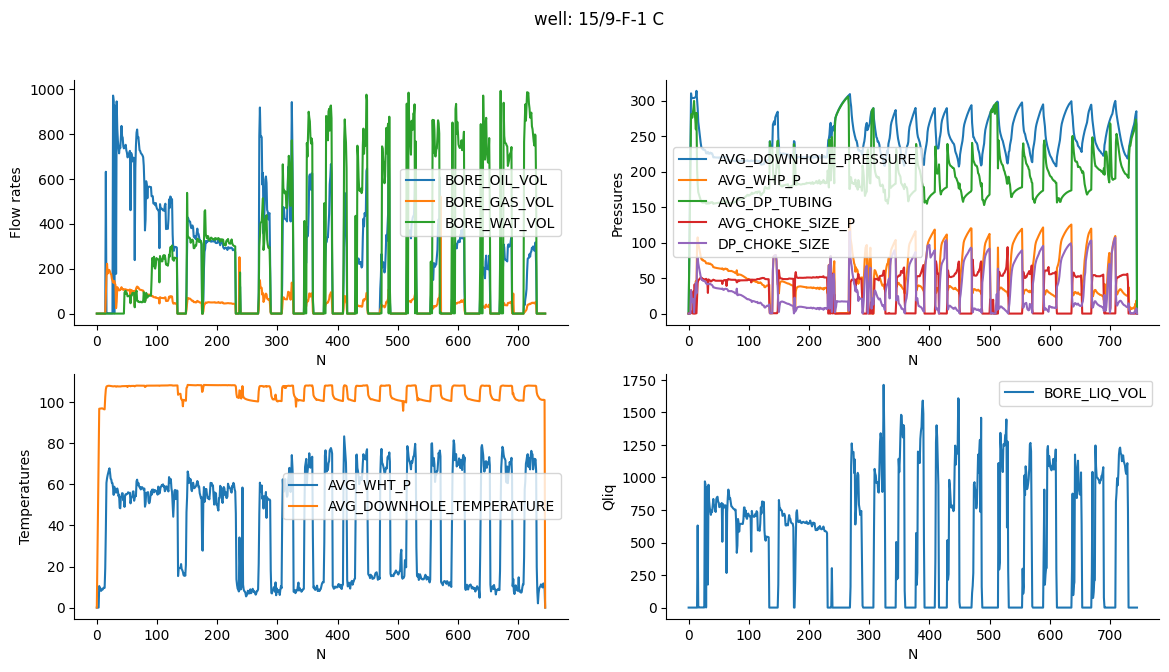

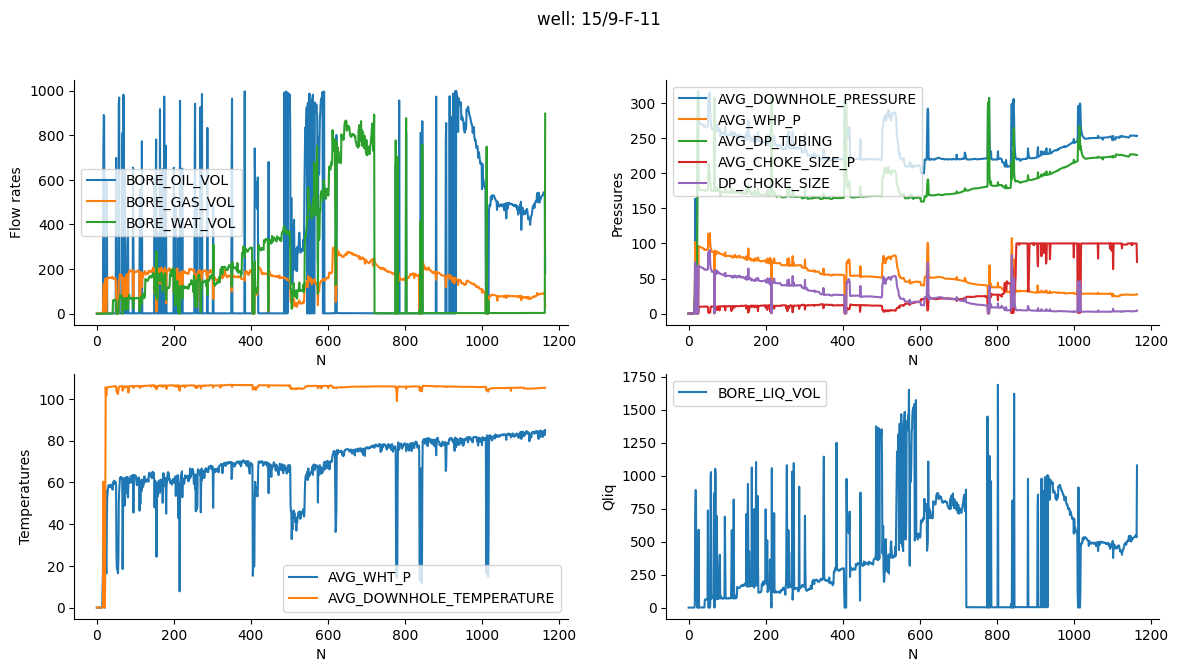

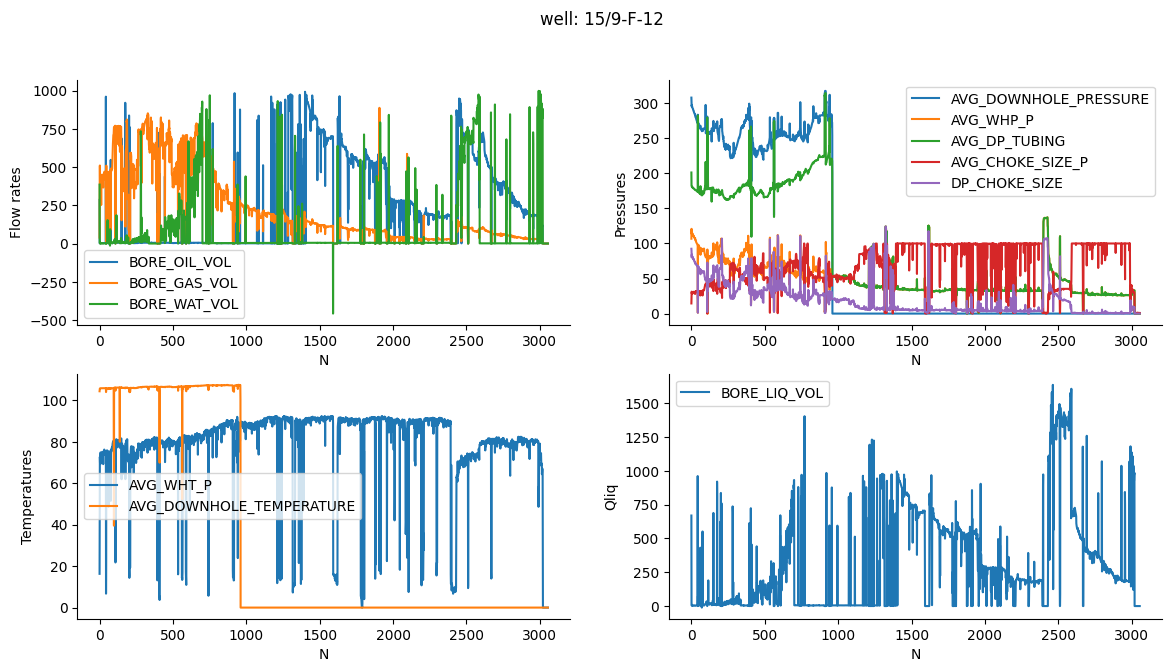

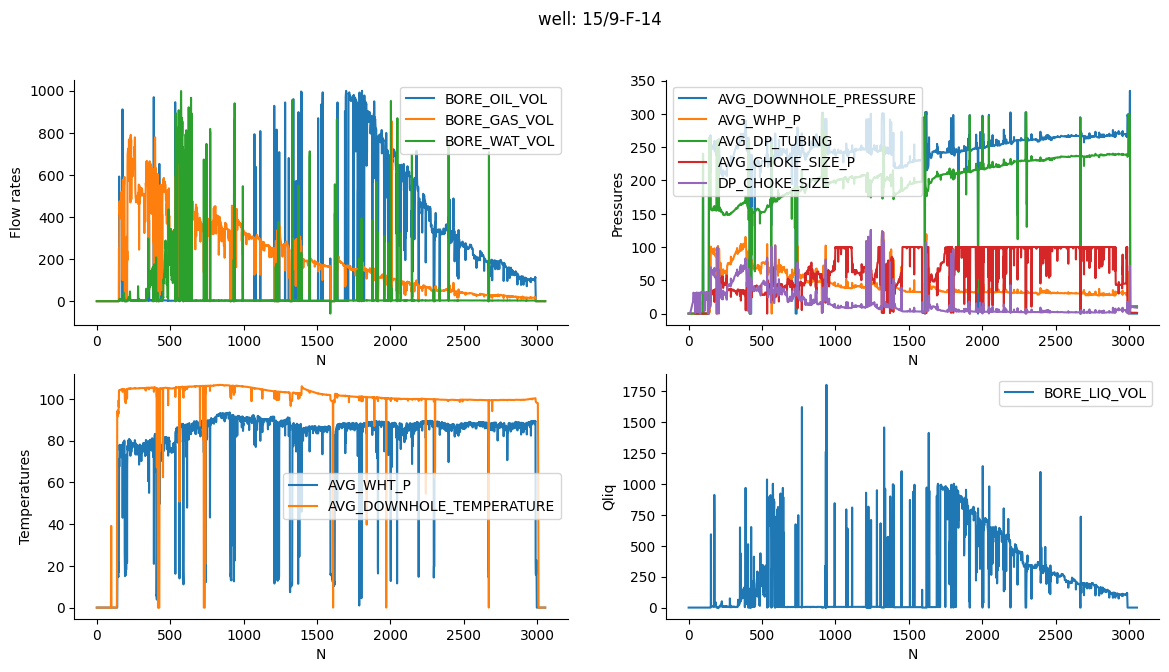

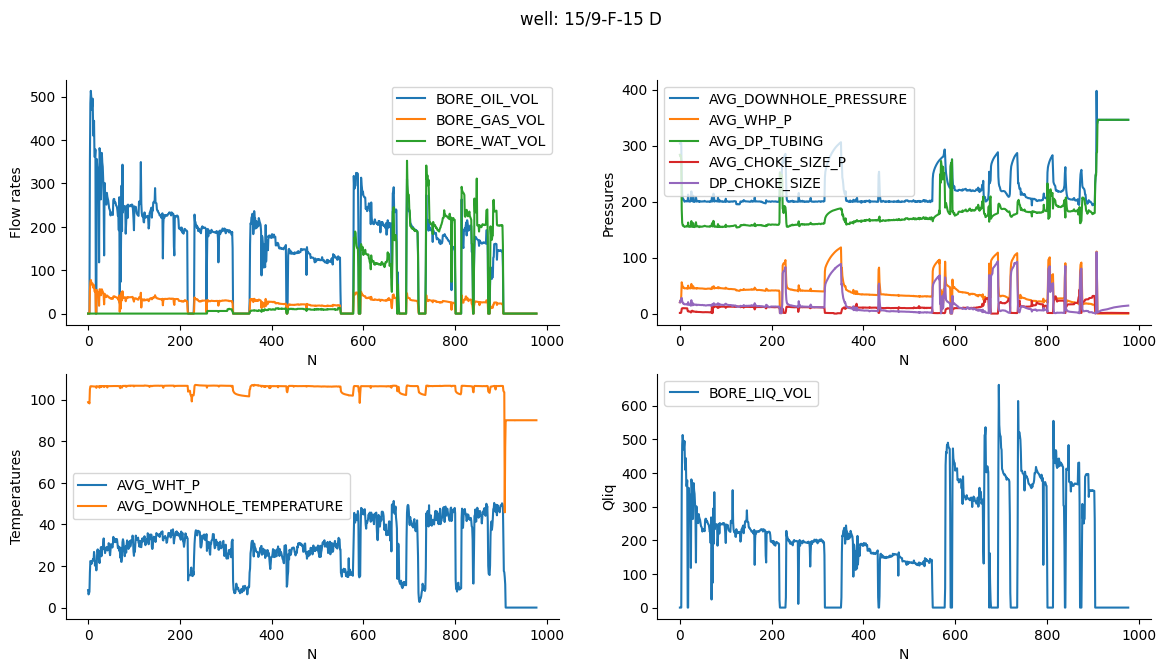

In [1255]:
for well in pwells[:-1]:
    f, ax = plt.subplots(2,2,figsize=(14,7))
    for q in v[:3]:
        sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=q, ax=ax[0,0], label=q)
    for q in v[4:9]:    
        sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=q, ax=ax[0,1], label=q)
    for q in v[9:11]:
        sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=q, ax=ax[1,0], label=q)

    for q in [v[3]]:
        sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=q, ax=ax[1,1], label=q)
    # for q in [v[12]]:
    #     sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=q, ax=ax[1,1].twinx(), label=q, color='r')

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()
    ax[0,0].set_ylabel('Flow rates')
    ax[0,1].set_ylabel('Pressures')
    ax[1,0].set_ylabel('Temperatures')
    ax[1,1].set_ylabel('Qliq')

    plt.suptitle('well: '+well)
pass;

Filtering Data

In [1256]:
df = df.dropna(subset=v)
# df_filt = df.dropna(subset=v)

# retirando valores zero de todas as colunas de Pressão
# for c in v[4:9]:
#     # print(c)
#     df = df[df[c] > 0]

# df_filt = df[df.AVG_DOWNHOLE_PRESSURE>0]

In [1257]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8740 entries, 0 to 9000
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATEPRD                   8740 non-null   object 
 1   N                         8740 non-null   int64  
 2   month                     8740 non-null   int64  
 3   year                      8740 non-null   int64  
 4   month-year                8740 non-null   object 
 5   WELL_BORE_CODE            8740 non-null   object 
 6   NPD_WELL_BORE_CODE        8740 non-null   int64  
 7   NPD_WELL_BORE_NAME        8740 non-null   object 
 8   NPD_FIELD_CODE            8740 non-null   int64  
 9   NPD_FIELD_NAME            8740 non-null   object 
 10  NPD_FACILITY_CODE         8740 non-null   int64  
 11  NPD_FACILITY_NAME         8740 non-null   object 
 12  ON_STREAM_HRS             8740 non-null   float64
 13  AVG_DOWNHOLE_PRESSURE     8740 non-null   float64
 14  AVG_DOWN

DATEPRD                        0
N                              0
month                          0
year                           0
month-year                     0
WELL_BORE_CODE                 0
NPD_WELL_BORE_CODE             0
NPD_WELL_BORE_NAME             0
NPD_FIELD_CODE                 0
NPD_FIELD_NAME                 0
NPD_FACILITY_CODE              0
NPD_FACILITY_NAME              0
ON_STREAM_HRS                  0
AVG_DOWNHOLE_PRESSURE          0
AVG_DOWNHOLE_TEMPERATURE       0
AVG_DP_TUBING                  0
AVG_ANNULUS_PRESS           1236
AVG_CHOKE_SIZE_P               0
AVG_CHOKE_UOM                  0
AVG_WHP_P                      0
AVG_WHT_P                      0
DP_CHOKE_SIZE                  0
BORE_OIL_VOL                   0
BORE_GAS_VOL                   0
BORE_WAT_VOL                   0
BORE_WI_VOL                 8740
FLOW_KIND                      0
WELL_TYPE                      0
AVG_RS                         0
BORE_LIQ_VOL                   0
dtype: int

In [1258]:
for well in pwells:
    print (well)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


#### Rate Identification (ARX)

SISO

In [1259]:
dict_results = {
    'outvar':    [],
    'invar':     [],
    'n_inputs':     [],
    'well':      [],

    'model_class':     [],
    'r2':        [],
    'mae':       [],
    'order':    [],

    'model':     [],
    'y_te':     [],
    'y_pred':     [],
}

In [1260]:
p_train = .7
steps_ahead = None # None = FRsim

orders = [5,15,30,50, 75]

# outvars = ['BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_LIQ_VOL', 'WCT', 'GOR']
outvars = ['BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_LIQ_VOL']

invars = v[4:] # no rates, no ratios
invars


['AVG_DOWNHOLE_PRESSURE',
 'AVG_WHP_P',
 'AVG_DP_TUBING',
 'AVG_CHOKE_SIZE_P',
 'DP_CHOKE_SIZE',
 'AVG_WHT_P',
 'AVG_DOWNHOLE_TEMPERATURE']

In [1261]:
for well in pwells[:-1]:
    print ('==================== Well '+well+' ================')
    for outvar in outvars:
        for invar in tqdm(invars, desc='Predicting '+outvar+'... Input vars loop'):
            
            if outvar != invar:
                ar_best_r2 = -100
                nar_best_r2 = -100

                X1 = df[df['NPD_WELL_BORE_NAME'] == well][invar].values.astype(float)
                y = df[df['NPD_WELL_BORE_NAME'] == well][outvar].values.astype(float)

                X1 = MinMaxScaler().fit_transform(np.array([X1]).T)
                
                i_train = int(X1.shape[0]*p_train)
                
                X_tr = X1[:i_train].reshape(-1, 1)
                y_tr = y[:i_train].reshape(-1, 1)
                X_te = X1[i_train:].reshape(-1, 1)
                y_te = y[i_train:].reshape(-1, 1)

                for io, o in enumerate(orders):
                    na = o
                    nb = o
                    ne = 3
                    nl = 2

                    model_ARMAX = FROLS(
                        order_selection=True,
                        ylag=na, xlag=nb, 
                        # elag=ne,
                        basis_function=Polynomial(degree=1),
                        n_terms=o,
                        # model_type='NARMAX',
                        info_criteria='aic',
                        estimator='least_squares',
                        extended_least_squares=False,
                    )
                    # model_NARMAX = FROLS(
                    #     order_selection=True,
                    #     ylag=na, xlag=nb,#elag=ne,
                    #     basis_function=Polynomial(degree=nl),
                    #     n_terms=o,
                    #     # model_type='NARMAX',
                    #     info_criteria='aic',
                    #     estimator='least_squares',
                    #     extended_least_squares=False,
                    # )

                    # model_NARMAX.fit(X=X_tr, y=y_tr)
                    model_ARMAX.fit(X=X_tr, y=y_tr)

                    # y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X_te, y=y_te, steps_ahead=steps_ahead)
                    y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X_te, y=y_te, steps_ahead=steps_ahead)
                    y_te_pr_FS_ARMAX = [0 if i < 0 else i for i in y_te_pr_FS_ARMAX]

                    try:    
                        r2_ARMAX = r2_score(y_te, y_te_pr_FS_ARMAX)
                        if r2_ARMAX < -1000: r2_ARMAX = -1000                                            
                        mae_ARMAX = mae(y_te, y_te_pr_FS_ARMAX)
                    except:
                        r2_ARMAX = 0
                        mae_ARMAX = 1e6
                    pass
                    # try:    
                    #     r2_NARMAX = r2_score(y_te, y_te_pr_FS_NARMAX)            
                    #     if r2_NARMAX < -1000: r2_NARMAX = -1000                                            
                    #     mae_NARMAX = mae(y_te, y_te_pr_FS_NARMAX)
                    # except:
                    #     r2_NARMAX = 0
                    #     mae_NARMAX = 1e6
                    # pass

                    if r2_ARMAX > ar_best_r2 and r2_ARMAX < 1: 
                        ar_best_order = o
                        ar_best_r2 = r2_ARMAX
                        ar_best_mae = mae_ARMAX
                        ar_best_model = model_ARMAX
                        ar_best_pred = y_te_pr_FS_ARMAX

                    # if r2_NARMAX > nar_best_r2 and r2_NARMAX < 1:
                    #     nar_best_order = o
                    #     nar_best_r2 = r2_NARMAX
                    #     nar_best_mae = mae_NARMAX
                    #     nar_best_model = model_NARMAX

                # print (outvar, invar)

                dict_results['well'].append(well)
                dict_results['outvar'].append(outvar)
                dict_results['invar'].append(invar)
                dict_results['n_inputs'].append(1)
                dict_results['model_class'].append('ARX')
                dict_results['r2'].append(ar_best_r2)
                dict_results['mae'].append(ar_best_mae)
                dict_results['order'].append(ar_best_order)
                dict_results['model'].append(ar_best_model)
                dict_results['y_te'].append(y_te)
                dict_results['y_pred'].append(ar_best_pred)
                
                # results['well'].append(well)
                # results['outvar'].append(outvar)
                # results['invar'].append(invar)
                # results['model_class'].append('NARMAX')
                # results['r2'].append(nar_best_r2)
                # results['mae'].append(nar_best_mae)
                # results['order'].append(nar_best_order)
                # results['model'].append(nar_best_model)            
pass;

==================== Well 15/9-F-1 C ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [00:15<00:00,  2.14s/it]


==================== Well 15/9-F-11 ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


==================== Well 15/9-F-12 ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [00:43<00:00,  6.17s/it]


==================== Well 15/9-F-14 ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [00:40<00:00,  5.85s/it]


==================== Well 15/9-F-15 D ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


In [1262]:
df_results = pd.DataFrame(dict_results)

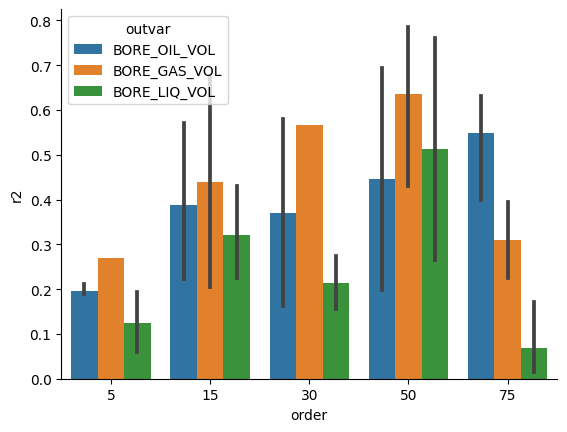

In [1263]:
sns.barplot(data=df_results[df_results['r2']>0], x='order', y='r2', hue='outvar');

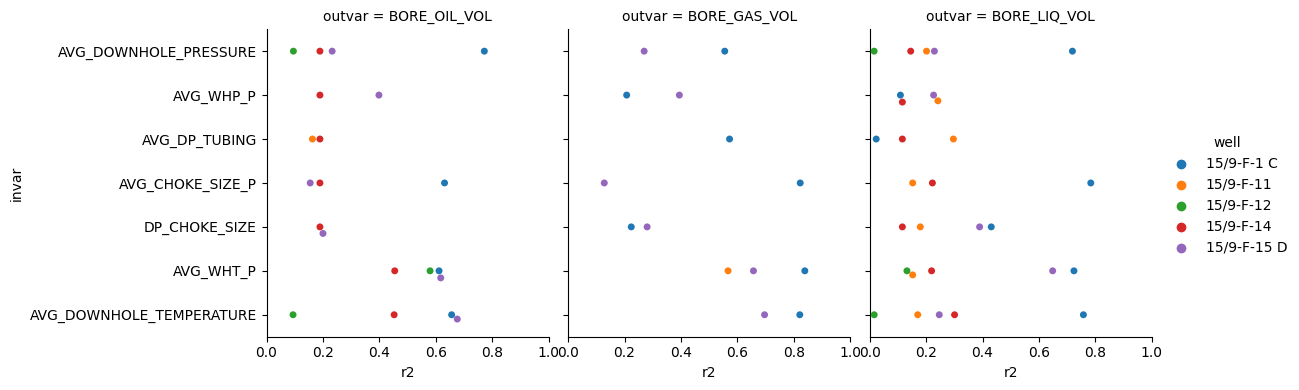

In [1264]:
sns.catplot(data=df_results, y='invar', x='r2', hue='well', col='outvar', col_wrap=3, height=4, aspect=1, palette='tab10', kind='swarm')
plt.xlim((0,1))

# dfr.groupby(['well', 'invar'])['r2'].max().sort_values(ascending=False)

pass;

In [1265]:
df_results.sort_values('r2', ascending=False).head(20)
# df_results.sort_values('r2', ascending=False).head(20).groupby(['well'])['well','r2'].max().sort_values(by='r2', ascending=False)

outvar                     invar  n_inputs         well  \
12   BORE_GAS_VOL                 AVG_WHT_P         1   15/9-F-1 C   
10   BORE_GAS_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C   
13   BORE_GAS_VOL  AVG_DOWNHOLE_TEMPERATURE         1   15/9-F-1 C   
17   BORE_LIQ_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C   
0    BORE_OIL_VOL     AVG_DOWNHOLE_PRESSURE         1   15/9-F-1 C   
20   BORE_LIQ_VOL  AVG_DOWNHOLE_TEMPERATURE         1   15/9-F-1 C   
19   BORE_LIQ_VOL                 AVG_WHT_P         1   15/9-F-1 C   
14   BORE_LIQ_VOL     AVG_DOWNHOLE_PRESSURE         1   15/9-F-1 C   
97   BORE_GAS_VOL  AVG_DOWNHOLE_TEMPERATURE         1  15/9-F-15 D   
90   BORE_OIL_VOL  AVG_DOWNHOLE_TEMPERATURE         1  15/9-F-15 D   
96   BORE_GAS_VOL                 AVG_WHT_P         1  15/9-F-15 D   
6    BORE_OIL_VOL  AVG_DOWNHOLE_TEMPERATURE         1   15/9-F-1 C   
103  BORE_LIQ_VOL                 AVG_WHT_P         1  15/9-F-15 D   
3    BORE_OIL_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C   
89   BORE_OIL_VOL                 AVG_WHT_P         1  15/9-F-15 D   
5    BORE_OIL_VOL                 AVG_WHT_P         1   15/9-F-1 C   
47   BORE_OIL_VOL                 AVG_WHT_P         1    15/9-F-12   
9    BORE_GAS_VOL             AVG_DP_TUBING         1   15/9-F-1 C   
33   BORE_GAS_VOL                 AVG_WHT_P         1    15/9-F-11   
7    BORE_GAS_VOL     AVG_DOWNHOLE_PRESSURE         1   15/9-F-1 C   

    model_class        r2                   mae  order  \
12          ARX  0.838692   [9.525943560978689]     50   
10          ARX  0.822398   [11.25815642967139]     50   
13          ARX  0.820926  [11.216493833989576]     50   
17          ARX  0.783497  [136.90804725740222]     50   
0           ARX  0.771569   [38.73822690356595]     50   
20          ARX  0.757382  [149.74525939246934]     50   
19          ARX  0.723880  [182.32274084940323]     15   
14          ARX  0.718469  [169.52660146723932]     50   
97          ARX  0.696051  [4.0913109726022885]     15   
90          ARX  0.675628  [26.568494616147095]     15   
96          ARX  0.656752   [5.739911163263524]     15   
6           ARX  0.655788  [49.038382874176556]     50   
103         ARX  0.648426   [82.09893097475657]     15   
3           ARX  0.630590   [56.49722713421145]     75   
89          ARX  0.617132   [31.50939731997391]     75   
5           ARX  0.611176  [51.326205951787834]     50   
47          ARX  0.579341  [101.89823889809581]     30   
9           ARX  0.572028  [19.761717698514712]     50   
33          ARX  0.566715   [24.43778001353486]     30   
7           ARX  0.555014  [20.512230672849327]     50   

                                                 model  \
12   <sysidentpy.model_structure_selection.forward_...   
10   <sysidentpy.model_structure_selection.forward_...   
13   <sysidentpy.model_structure_selection.forward_...   
17   <sysidentpy.model_structure_selection.forward_...   
0    <sysidentpy.model_structure_selection.forward_...   
20   <sysidentpy.model_structure_selection.forward_...   
19   <sysidentpy.model_structure_selection.forward_...   
14   <sysidentpy.model_structure_selection.forward_...   
97   <sysidentpy.model_structure_selection.forward_...   
90   <sysidentpy.model_structure_selection.forward_...   
96   <sysidentpy.model_structure_selection.forward_...   
6    <sysidentpy.model_structure_selection.forward_...   
103  <sysidentpy.model_structure_selection.forward_...   
3    <sysidentpy.model_structure_selection.forward_...   
89   <sysidentpy.model_structure_selection.forward_...   
5    <sysidentpy.model_structure_selection.forward_...   
47   <sysidentpy.model_structure_selection.forward_...   
9    <sysidentpy.model_structure_selection.forward_...   
33   <sysidentpy.model_structure_selection.forward_...   
7    <sysidentpy.model_structure_selection.forward_...   

                                                  y_te  \
12   [[58.901], [60.948], [64.122], [64.317]

In [1266]:
best_ar_model = df_results.sort_values('r2', ascending=False).head(1).model.values[0]
r = pd.DataFrame(
    results(
        best_ar_model.final_model, best_ar_model.theta, best_ar_model.err,
        best_ar_model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r.iloc[:10]

Regressors   Parameters             ERR
0     y(k-1)   4.6583E-01  8.47130457E-01
1    y(k-33)   1.7117E-01  1.37518602E-02
2    x1(k-1)   5.1134E+01  6.87725334E-03
3   x1(k-33)  -3.1401E+01  4.82796833E-03
4   x1(k-32)   1.6373E+01  1.17468520E-03
5    y(k-48)   4.6589E-02  1.03401121E-03
6   x1(k-18)  -3.6359E-01  3.11591811E-03
7    x1(k-2)  -1.1420E+01  8.88300759E-04
8     y(k-7)   7.8378E-02  1.03363310E-03
9    x1(k-5)  -1.9420E+01  7.44984137E-04

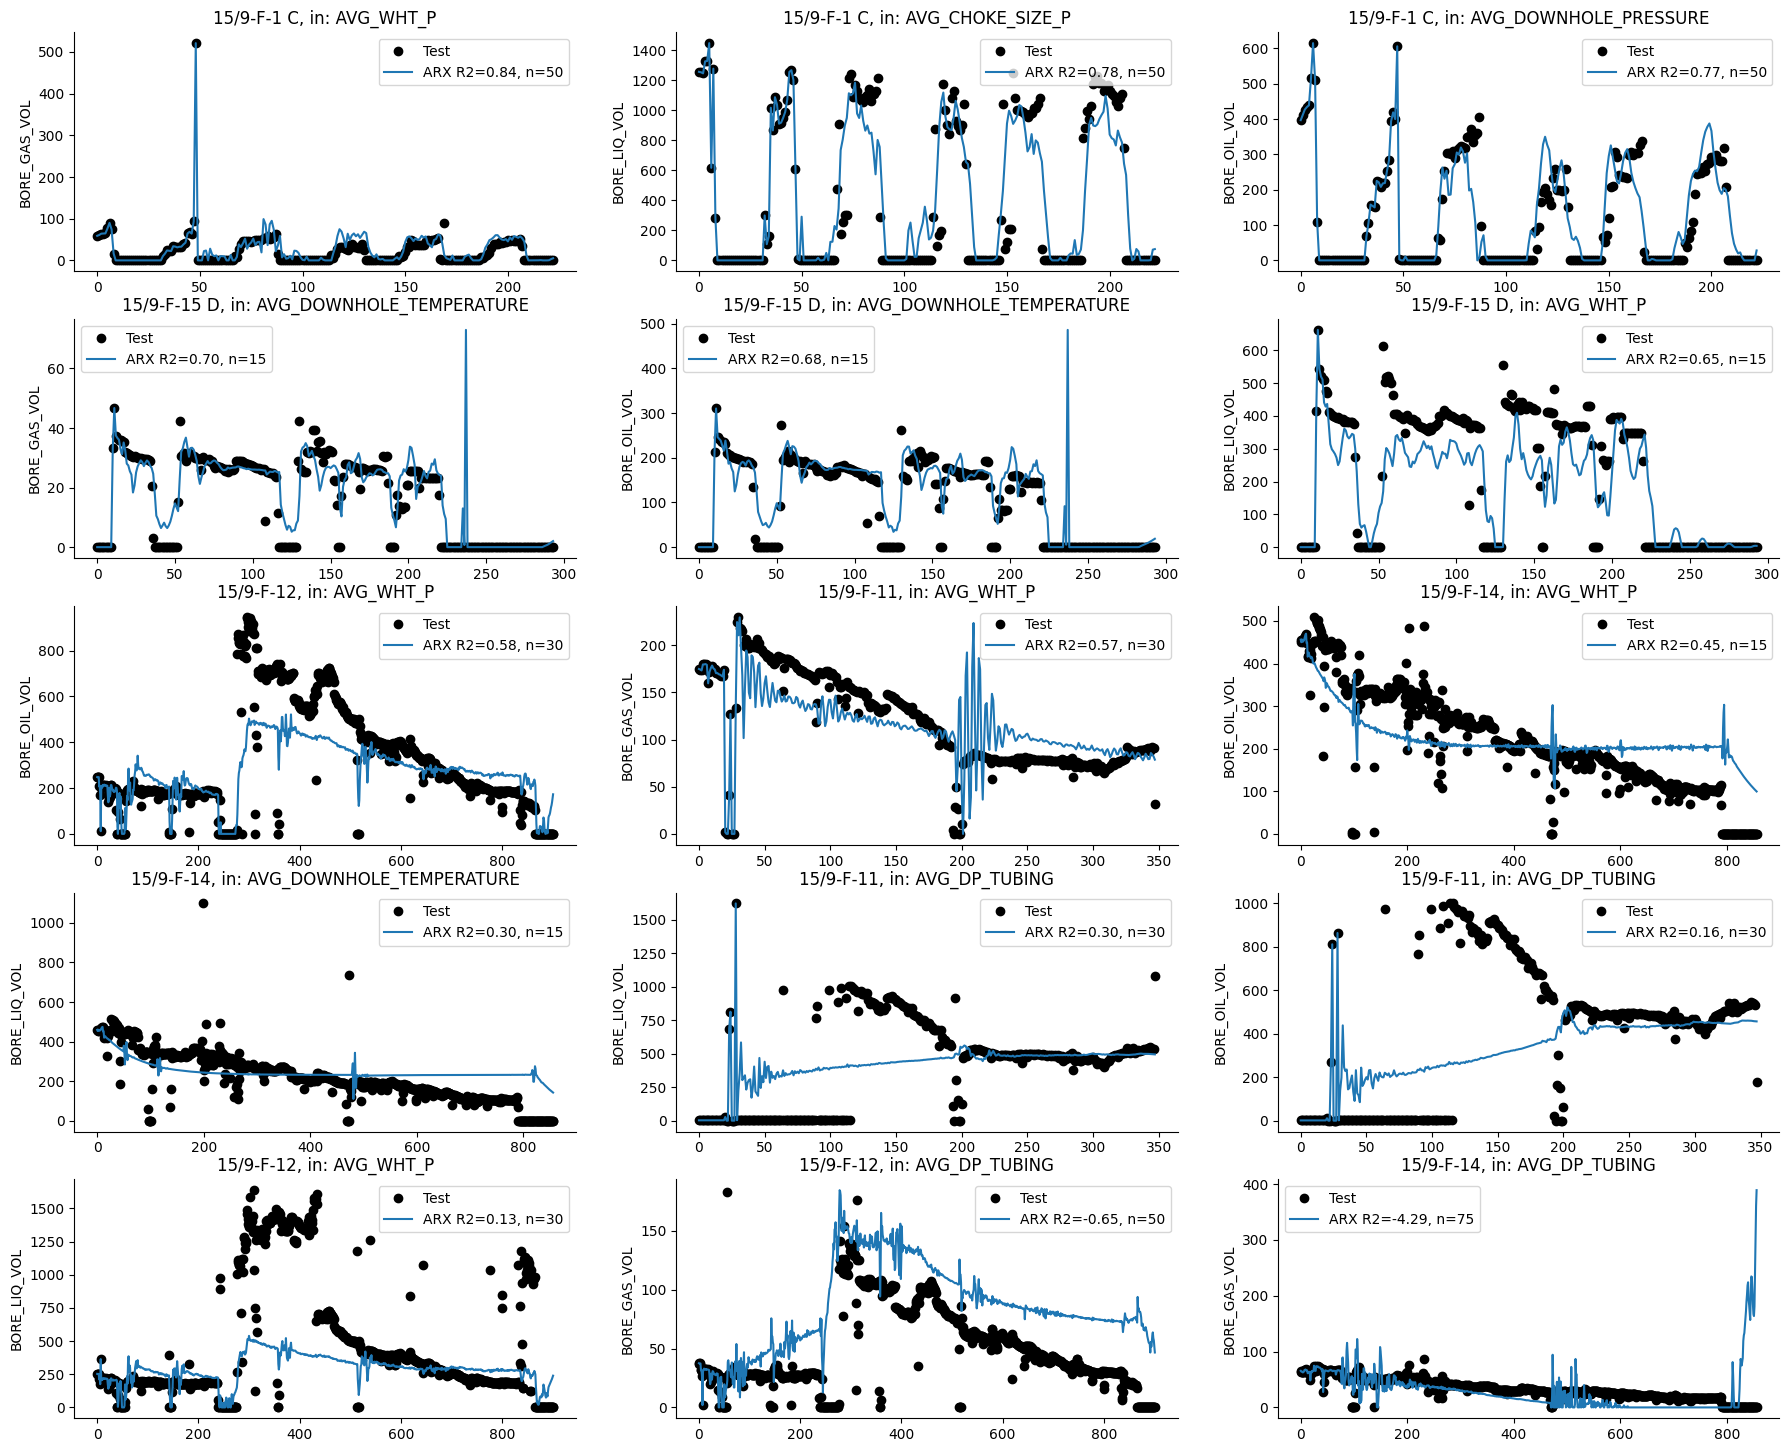

In [1267]:
# plotting best results
fig, ax = plt.subplots(5,3,figsize=(22,18))
ax = ax.flatten()
for i, m in enumerate(df_results.sort_values('r2', ascending=False).drop_duplicates(['outvar' ,'well']).values):
    # print (m[:5])
    ax[i].plot(m[-2], 'ko', label='Test')
    ax[i].set_title(m[3]+', in: '+m[1])
    ax[i].set_ylabel(m[0])
    ax[i].plot(m[-1], label=f'ARX R2={m[5]:.2f}, n={m[7]}')
    ax[i].legend()
pass;

MISO - Most relevant vars to combine

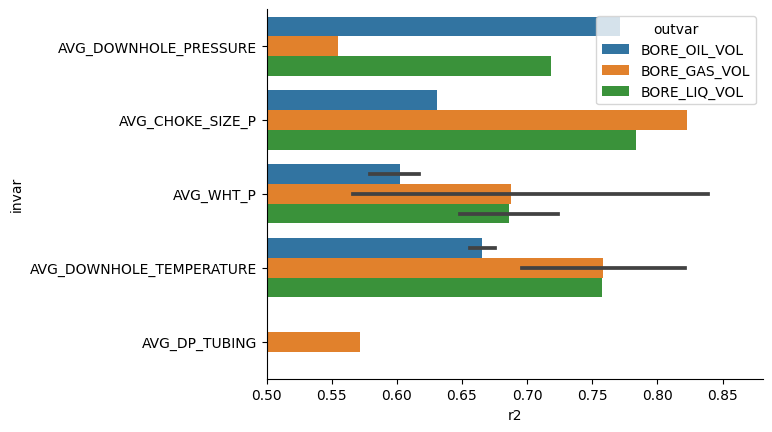

In [1268]:
sns.barplot(data=df_results[df_results['r2']>0.5], y='invar', x='r2', hue='outvar');
plt.xlim((0.5,None));

In [1269]:
best_invars = [
    'AVG_DOWNHOLE_PRESSURE', 
    'AVG_CHOKE_SIZE_P',
    'AVG_DOWNHOLE_TEMPERATURE',
    'AVG_WHT_P',
    ]


for i in combinations(best_invars, 2):    i
print()
for i in combinations(best_invars, 3):    i


('AVG_DOWNHOLE_PRESSURE', 'AVG_CHOKE_SIZE_P')

('AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE')

('AVG_DOWNHOLE_PRESSURE', 'AVG_WHT_P')

('AVG_CHOKE_SIZE_P', 'AVG_DOWNHOLE_TEMPERATURE')

('AVG_CHOKE_SIZE_P', 'AVG_WHT_P')

('AVG_DOWNHOLE_TEMPERATURE', 'AVG_WHT_P')

('AVG_DOWNHOLE_PRESSURE', 'AVG_CHOKE_SIZE_P', 'AVG_DOWNHOLE_TEMPERATURE')

('AVG_DOWNHOLE_PRESSURE', 'AVG_CHOKE_SIZE_P', 'AVG_WHT_P')

('AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_WHT_P')

('AVG_CHOKE_SIZE_P', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_WHT_P')

2ISO

In [1270]:
dict_results2 = {
    'outvar':    [],
    'invar':     [],
    'well':      [],
    'n_inputs':      [],

    'model_class':     [],
    'r2':        [],
    'mae':       [],
    'order':    [],

    'model':     [],
    'y_te':     [],
    'y_pred':     [],
}

In [1271]:
# for well in [pwells[0]]:
for well in pwells[:-1]:
    print ('==================== Well '+well+' ================')
    for outvar in outvars:
        for invar in tqdm(combinations(best_invars,2), desc='Predicting '+outvar+'... Input vars loop'):
            invar = list(invar) # tuple to list

            ar_best_r2 = -100
            nar_best_r2 = -100

            X1 = df[df['NPD_WELL_BORE_NAME'] == well][invar].values.astype(float)
            y = df[df['NPD_WELL_BORE_NAME'] == well][outvar].values.astype(float)

            X1 = MinMaxScaler().fit_transform(X1)
            
            i_train = int(X1.shape[0]*p_train)
            
            X_tr = X1[:i_train] #.reshape(-1, 1)
            y_tr = y[:i_train].reshape(-1, 1)
            X_te = X1[i_train:] #.reshape(-1, 1)
            y_te = y[i_train:].reshape(-1, 1)

            for io, o in enumerate(orders):
                na = o
                nb = [o] * X1.shape[1]
                ne = 3
                nl = 2

                model_ARMAX = FROLS(
                    order_selection=True,
                    ylag=na, xlag=nb, 
                    # elag=ne,
                    basis_function=Polynomial(degree=1),
                    n_terms=X1.shape[1] * o,
                    # model_type='NARMAX',
                    info_criteria='aic',
                    estimator='least_squares',
                    extended_least_squares=False,
                )
                model_ARMAX.fit(X=X_tr, y=y_tr)

                y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X_te, y=y_te, steps_ahead=steps_ahead)
                y_te_pr_FS_ARMAX = [0 if i < 0 else i for i in y_te_pr_FS_ARMAX]

                try:    
                    r2_ARMAX = r2_score(y_te, y_te_pr_FS_ARMAX)
                    if r2_ARMAX < -1000: r2_ARMAX = -1000                                            
                    mae_ARMAX = mae(y_te, y_te_pr_FS_ARMAX)
                except:
                    r2_ARMAX = 0
                    mae_ARMAX = 1e6
                pass

                if r2_ARMAX > ar_best_r2 and r2_ARMAX < 1: 
                    ar_best_order = o
                    ar_best_r2 = r2_ARMAX
                    ar_best_mae = mae_ARMAX
                    ar_best_model = model_ARMAX
                    ar_best_pred = y_te_pr_FS_ARMAX

            dict_results2['well'].append(well)
            dict_results2['outvar'].append(outvar)
            dict_results2['invar'].append(invar)
            dict_results2['n_inputs'].append(2)
            dict_results2['model_class'].append('ARX')
            dict_results2['r2'].append(ar_best_r2)
            dict_results2['mae'].append(ar_best_mae)
            dict_results2['order'].append(ar_best_order)
            dict_results2['model'].append(ar_best_model)
            dict_results2['y_te'].append(y_te)
            dict_results2['y_pred'].append(ar_best_pred)
pass;

==================== Well 15/9-F-1 C ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [00:08,  1.49s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [00:07,  1.19s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [00:07,  1.20s/it]


==================== Well 15/9-F-11 ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [00:09,  1.59s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [00:09,  1.58s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [00:09,  1.63s/it]


==================== Well 15/9-F-12 ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [00:23,  3.94s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [00:24,  4.03s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [00:23,  3.89s/it]


==================== Well 15/9-F-14 ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [00:22,  3.82s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [00:22,  3.77s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [00:22,  3.73s/it]


==================== Well 15/9-F-15 D ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [00:10,  1.72s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [00:09,  1.66s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [00:09,  1.62s/it]


3ISO

In [1272]:
dict_results3 = {
    'outvar':    [],
    'invar':     [],
    'well':      [],
    'n_inputs':      [],

    'model_class':     [],
    'r2':        [],
    'mae':       [],
    'order':    [],

    'model':     [],
    'y_te':     [],
    'y_pred':     [],
}

In [1273]:
# for well in [pwells[0]]:
for well in pwells[:-1]:
    print ('==================== Well '+well+' ================')
    for outvar in outvars:
        for invar in tqdm(combinations(best_invars,3), desc='Predicting '+outvar+'... Input vars loop'):
            invar = list(invar) # tuple to list

            ar_best_r2 = -100
            nar_best_r2 = -100

            X1 = df[df['NPD_WELL_BORE_NAME'] == well][invar].values.astype(float)
            y = df[df['NPD_WELL_BORE_NAME'] == well][outvar].values.astype(float)

            X1 = MinMaxScaler().fit_transform(X1)
            
            i_train = int(X1.shape[0]*p_train)
            
            X_tr = X1[:i_train] #.reshape(-1, 1)
            y_tr = y[:i_train].reshape(-1, 1)
            X_te = X1[i_train:] #.reshape(-1, 1)
            y_te = y[i_train:].reshape(-1, 1)

            for io, o in enumerate(orders):
                na = o
                nb = [o] * X1.shape[1]
                ne = 3
                nl = 2

                model_ARMAX = FROLS(
                    order_selection=True,
                    ylag=na, xlag=nb, 
                    # elag=ne,
                    basis_function=Polynomial(degree=1),
                    n_terms=X1.shape[1] * o,
                    # model_type='NARMAX',
                    info_criteria='aic',
                    estimator='least_squares',
                    extended_least_squares=False,
                )
                model_ARMAX.fit(X=X_tr, y=y_tr)

                y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X_te, y=y_te, steps_ahead=steps_ahead)
                y_te_pr_FS_ARMAX = [0 if i < 0 else i for i in y_te_pr_FS_ARMAX]

                try:    
                    r2_ARMAX = r2_score(y_te, y_te_pr_FS_ARMAX)
                    if r2_ARMAX < -1000: r2_ARMAX = -1000                                            
                    mae_ARMAX = mae(y_te, y_te_pr_FS_ARMAX)
                except:
                    r2_ARMAX = 0
                    mae_ARMAX = 1e6
                pass

                if r2_ARMAX > ar_best_r2 and r2_ARMAX < 1: 
                    ar_best_order = o
                    ar_best_r2 = r2_ARMAX
                    ar_best_mae = mae_ARMAX
                    ar_best_model = model_ARMAX
                    ar_best_pred = y_te_pr_FS_ARMAX

            dict_results3['well'].append(well)
            dict_results3['outvar'].append(outvar)
            dict_results3['invar'].append(invar)
            dict_results3['n_inputs'].append(3)
            dict_results3['model_class'].append('ARX')
            dict_results3['r2'].append(ar_best_r2)
            dict_results3['mae'].append(ar_best_mae)
            dict_results3['order'].append(ar_best_order)
            dict_results3['model'].append(ar_best_model)
            dict_results3['y_te'].append(y_te)
            dict_results3['y_pred'].append(ar_best_pred)
pass;

==================== Well 15/9-F-1 C ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [00:05,  1.49s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [00:05,  1.40s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [00:05,  1.41s/it]


==================== Well 15/9-F-11 ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [00:07,  1.92s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [00:08,  2.01s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [00:07,  1.91s/it]


==================== Well 15/9-F-12 ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [00:15,  3.98s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [00:15,  3.89s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [00:16,  4.23s/it]


==================== Well 15/9-F-14 ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [00:16,  4.02s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [00:16,  4.02s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [00:16,  4.11s/it]


==================== Well 15/9-F-15 D ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [00:07,  1.75s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [00:07,  1.82s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [00:07,  1.83s/it]


In [1274]:
df_results2 = pd.DataFrame(dict_results2)
df_results3 = pd.DataFrame(dict_results3)

dfr = df_results.append(df_results2).append(df_results3)

In [1275]:
dfr.sort_values('r2', ascending=False).head(10)

outvar                                              invar  n_inputs  \
8   BORE_GAS_VOL                 [AVG_DOWNHOLE_PRESSURE, AVG_WHT_P]         2   
5   BORE_GAS_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_CHOKE_SIZE_P, AVG_...         3   
6   BORE_GAS_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATU...         3   
12  BORE_GAS_VOL                                          AVG_WHT_P         1   
4   BORE_GAS_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_CHOKE_SIZE_P, AVG_...         3   
57  BORE_OIL_VOL       [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE]         2   
10  BORE_GAS_VOL                                   AVG_CHOKE_SIZE_P         1   
6   BORE_GAS_VOL          [AVG_DOWNHOLE_PRESSURE, AVG_CHOKE_SIZE_P]         2   
13  BORE_GAS_VOL                           AVG_DOWNHOLE_TEMPERATURE         1   
11  BORE_GAS_VOL              [AVG_DOWNHOLE_TEMPERATURE, AVG_WHT_P]         2   

          well model_class        r2                   mae  order  \
8   15/9-F-1 C         ARX  0.849497   [9.148103622978525]     75   
5   15/9-F-1 C         ARX  0.843304   [9.117560179694689]     75   
6   15/9-F-1 C         ARX  0.841749   [9.328131188104079]     75   
12  15/9-F-1 C         ARX  0.838692   [9.525943560978689]     50   
4   15/9-F-1 C         ARX  0.828651   [9.404403753934105]     75   
57   15/9-F-14         ARX  0.824726  [31.603949892687467]     30   
10  15/9-F-1 C         ARX  0.822398   [11.25815642967139]     50   
6   15/9-F-1 C         ARX  0.822284    [9.39839798366931]     75   
13  15/9-F-1 C         ARX  0.820926  [11.216493833989576]     50   
11  15/9-F-1 C         ARX  0.798357   [10.38960346910206]     75   

                                                model  \
8   <sysidentpy.model_structure_selection.forward_...   
5   <sysidentpy.model_structure_selection.forward_...   
6   <sysidentpy.model_structure_selection.forward_...   
12  <sysidentpy.model_structure_selection.forward_...   
4   <sysidentpy.model_structure_selection.forward_...   
57  <sysidentpy.model_structure_selection.forward_...   
10  <sysidentpy.model_structure_selection.forward_...   
6   <sysidentpy.model_structure_selection.forward_...   
13  <sysidentpy.model_structure_selection.forward_...   
11  <sysidentpy.model_structure_selection.forward_...   

                                                 y_te  \
8   [[58.901], [60.948], [64.122], [64.317], [64.7...   
5   [[58.901], [60.948], [64.122], [64.317], [64.7...   
6   [[58.901], [60.948], [64.122], [64.317], [64.7...   
12  [[58.901], [60.948], [64.122], [64.317], [64.7...   
4   [[58.901], [60.948], [64.122], [64.317], [64.7...   
57  [[456.0], [450.0], [456.0], [456.0], [451.0], ...   
10  [[58.901], [60.948], [64.122], [64.317], [64.7...   
6   [[58.901], [60.948], [64.122], [64.317], [64.7...   
13  [[58.901], [60.948], [64.122], [64.317], [64.7...   
11  [[58.901], [60.948], [64.122], [64.317], [64.7...   

                                               y_pred  
8   [[58.901], [60.948], [64.122], [64.317], [64.7...  
5   [[58.901], [60.948], [64.122], [64.317], [64.7...  
6   [[58.901], [60.948], [64.122], [64.317], [64.7...  
12  [[58.901], [60.948], [64.122], [64.317], [64.7...  
4   [[58.901], [60.948], [64.122], [64.317], [64.7...  
57  [[456.0], [450.0], [456.0], [456.0], [451.0], ...  
10  [[58.901], [60.948], [64.122], [64.317], [64.7...  
6   [[58.901], [60.948], [64.122], [64.317], [64.7...  
13  [[58.901], [60.948], [64.122], [64.317], [64.7...  
11  [[58.901], [60.948], [64.122], [64.317], [64.7...

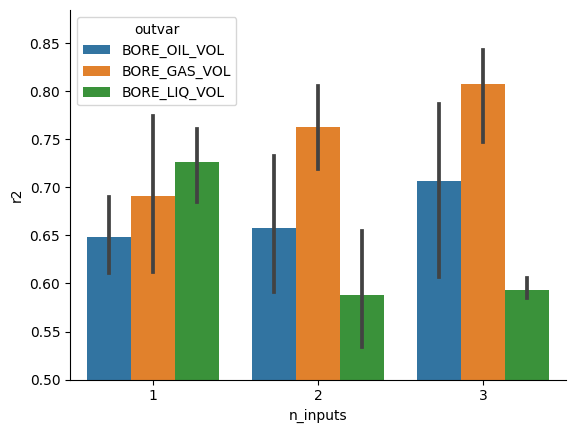

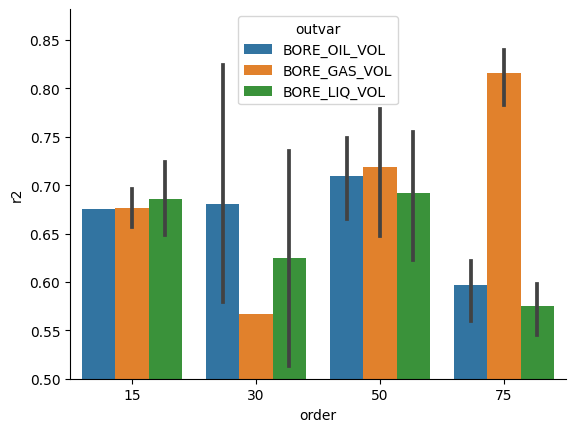

In [1276]:
sns.barplot(data=dfr[dfr['r2']>0.5], x='n_inputs', y='r2', hue='outvar')
plt.ylim((.5,None));
plt.figure()
sns.barplot(data=dfr[dfr['r2']>0.5], x='order', y='r2', hue='outvar')
plt.ylim((.5,None));

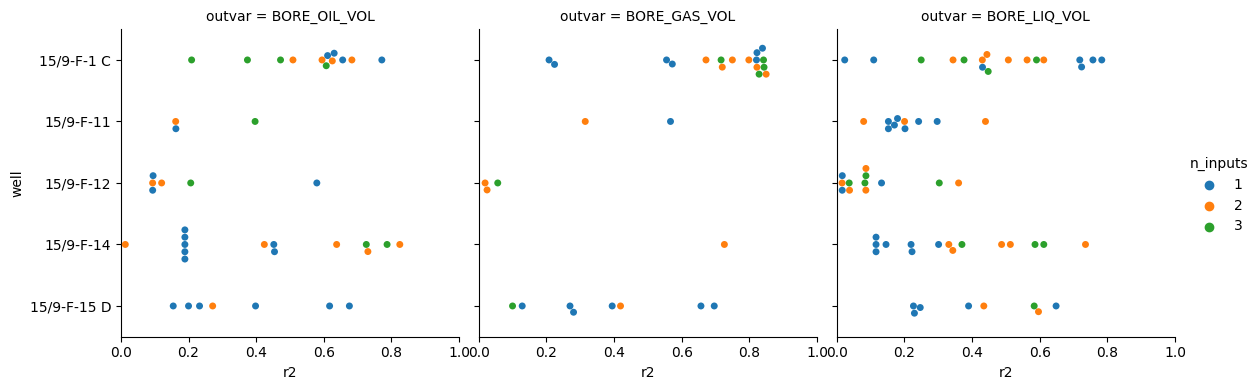

In [1277]:
sns.catplot(data=dfr, y='well', x='r2', hue='n_inputs', col='outvar', col_wrap=3, height=4, aspect=1, palette='tab10', kind='swarm')
plt.xlim((0,1));

In [1278]:
dfr.sort_values('r2', ascending=False).drop_duplicates(['outvar','well']).head(10)

outvar                                              invar  \
8    BORE_GAS_VOL                 [AVG_DOWNHOLE_PRESSURE, AVG_WHT_P]   
57   BORE_OIL_VOL       [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE]   
17   BORE_LIQ_VOL                                   AVG_CHOKE_SIZE_P   
0    BORE_OIL_VOL                              AVG_DOWNHOLE_PRESSURE   
69   BORE_LIQ_VOL       [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE]   
61   BORE_GAS_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATURE]   
97   BORE_GAS_VOL                           AVG_DOWNHOLE_TEMPERATURE   
90   BORE_OIL_VOL                           AVG_DOWNHOLE_TEMPERATURE   
103  BORE_LIQ_VOL                                          AVG_WHT_P   
47   BORE_OIL_VOL                                          AVG_WHT_P   

     n_inputs         well model_class        r2                   mae  order  \
8           2   15/9-F-1 C         ARX  0.849497   [9.148103622978525]     75   
57          2    15/9-F-14         ARX  0.824726  [31.603949892687467]     30   
17          1   15/9-F-1 C         ARX  0.783497  [136.90804725740222]     50   
0           1   15/9-F-1 C         ARX  0.771569   [38.73822690356595]     50   
69          2    15/9-F-14         ARX  0.735360             38.551202     30   
61          2    15/9-F-14         ARX  0.726032              6.276376     75   
97          1  15/9-F-15 D         ARX  0.696051  [4.0913109726022885]     15   
90          1  15/9-F-15 D         ARX  0.675628  [26.568494616147095]     15   
103         1  15/9-F-15 D         ARX  0.648426   [82.09893097475657]     15   
47          1    15/9-F-12         ARX  0.579341  [101.89823889809581]     30   

                                                 model  \
8    <sysidentpy.model_structure_selection.forward_...   
57   <sysidentpy.model_structure_selection.forward_...   
17   <sysidentpy.model_structure_selection.forward_...   
0    <sysidentpy.model_structure_selection.forward_...   
69   <sysidentpy.model_structure_selection.forward_...   
61   <sysidentpy.model_structure_selection.forward_...   
97   <sysidentpy.model_structure_selection.forward_...   
90   <sysidentpy.model_structure_selection.forward_...   
103  <sysidentpy.model_structure_selection.forward_...   
47   <sysidentpy.model_structure_selection.forward_...   

                                                  y_te  \
8    [[58.901], [60.948], [64.122], [64.317], [64.7...   
57   [[456.0], [450.0], [456.0], [456.0], [451.0], ...   
17   [[1255.0], [1252.0], [1245.0], [1325.0], [1327...   
0    [[397.0], [412.0], [427.0], [434.0], [439.0], ...   
69   [[459.159], [453.055], [459.087], [459.178], [...   
61   [[65.489], [64.161], [64.088], [64.071], [62.5...   
97   [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
90   [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
103  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
47   [[248.0], [247.0], [247.0], [248.0], [207.0], ...   

                                                y_pred  
8    [[58.901], [60.948], [64.122], [64.317], [64.7...  
57   [[456.0], [450.0], [456.0], [456.0], [451.0], ...  
17   [[1255.0], [1252.0], [1245.0], [1325.0], [1327...  
0    [[397.0], [412.0], [427.0], [434.0], [439.0], ...  
69   [[459.159], [453.055], [459.087], [459.178], [...  
61   [[65.489], [64.161], [64.088], [64.071], [62.5...  
97   [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
90   [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
103  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
47   [[248.0], [247.0], [247.0], [248.0], [207.0], ...

Save ARX results

In [1283]:
pickle.dump(dict_results,open('arx_dict_result.p', 'wb'))
pickle.dump(dict_results2,open('arx_dict_result2.p', 'wb'))
pickle.dump(dict_results3,open('arx_dict_result3.p', 'wb'))

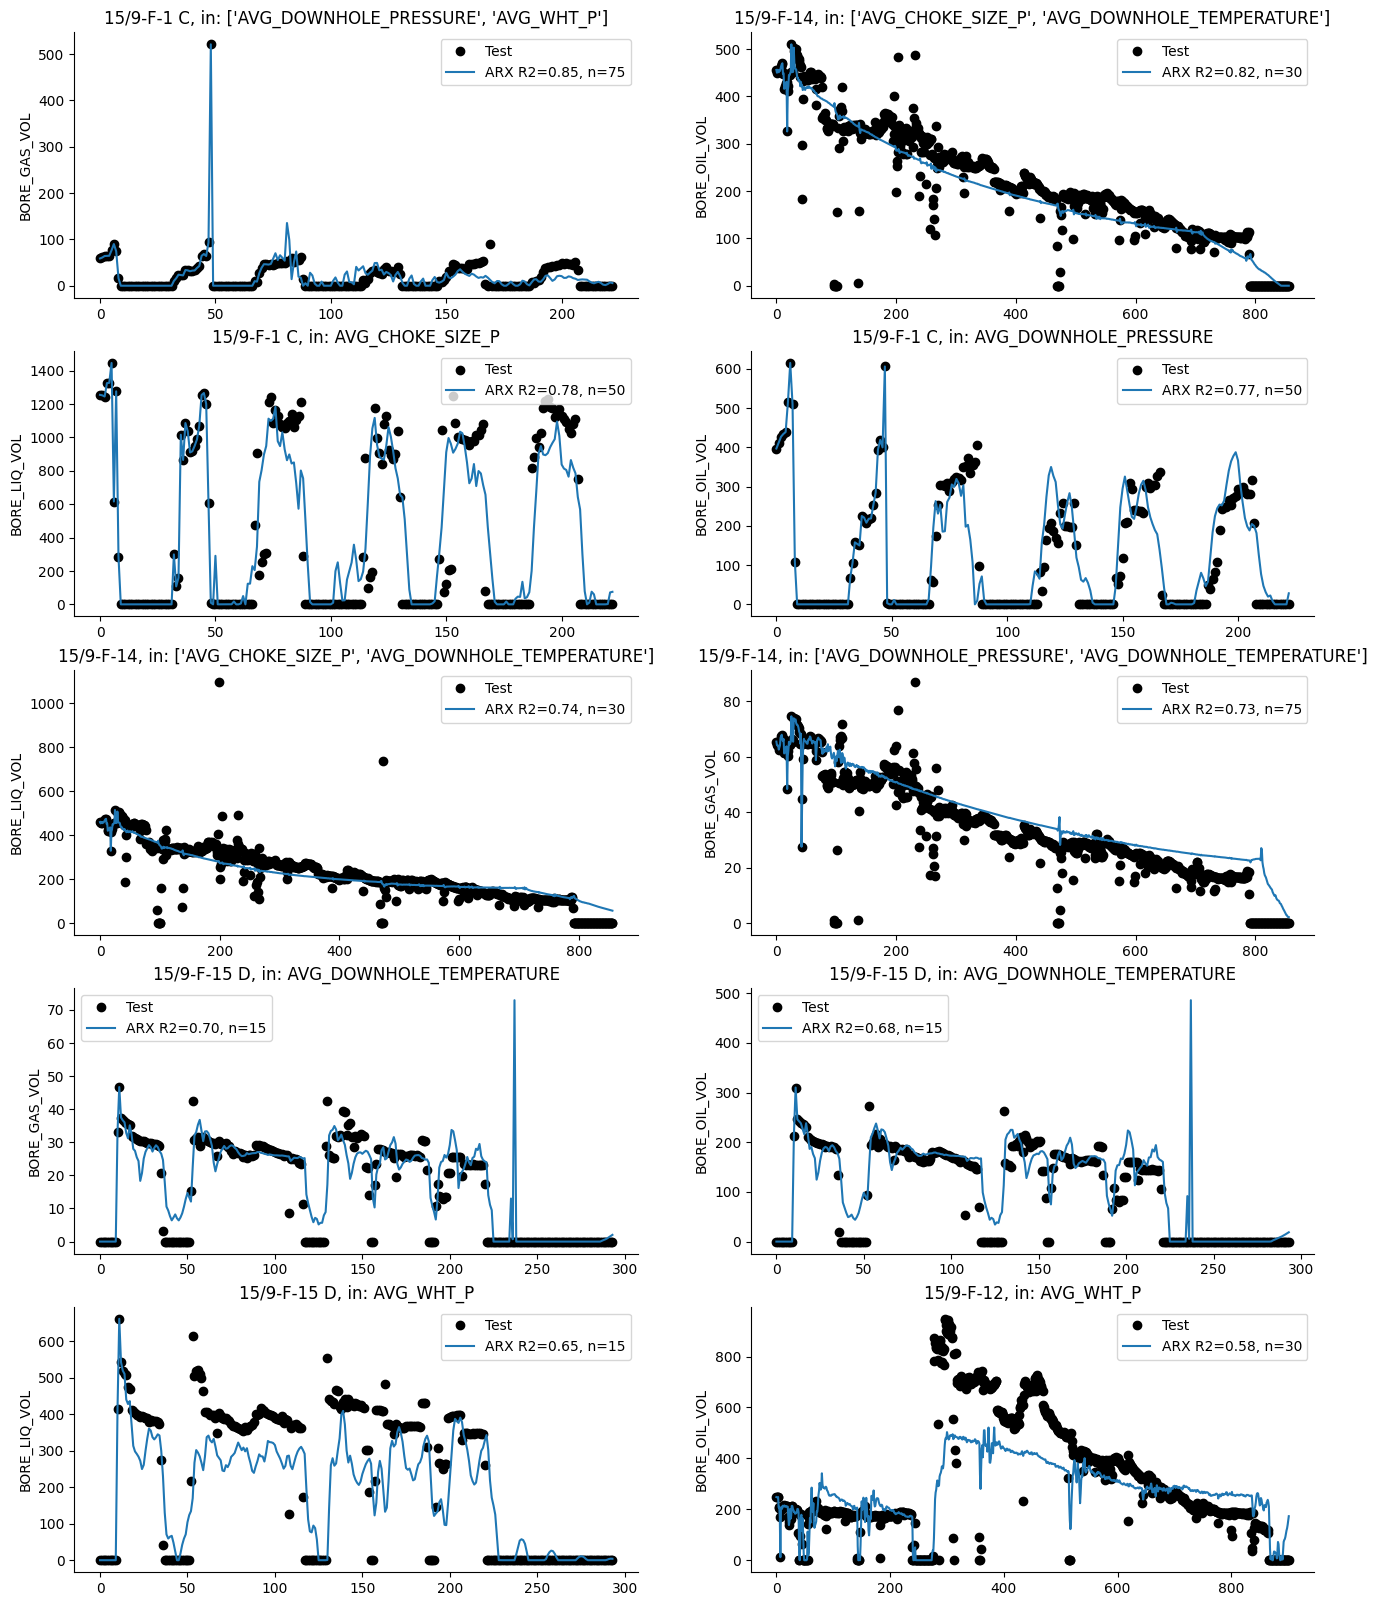

In [1279]:
# plotting best results
fig, ax = plt.subplots(5,2,figsize=(16,20))
ax = ax.flatten()
for i, m in enumerate(dfr.sort_values('r2', ascending=False).drop_duplicates(['outvar','well']).head(10).values):
    # print (m[:5])
    ax[i].plot(m[-2], 'ko', label='Test')
    ax[i].set_title(m[3]+', in: '+str(m[1]))
    ax[i].set_ylabel(m[0])
    ax[i].plot(m[-1], label=f'ARX R2={m[5]:.2f}, n={m[7]}')
    ax[i].legend()
pass;


#### Rate Identification (ARMAX)

SISO

In [1285]:
dict_armax_results = {
    'outvar':    [],
    'invar':     [],
    'n_inputs':     [],
    'well':      [],

    'model_class':     [],
    'r2':        [],
    'mae':       [],
    'order':    [],

    'model':     [],
    'y_te':     [],
    'y_pred':     [],
}

In [1286]:
p_train = .7
steps_ahead = None # None = FRsim

orders = [5,15,30,50,75]

# outvars = ['BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_LIQ_VOL', 'WCT', 'GOR']
outvars = ['BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_LIQ_VOL']

invars = v[4:] # no rates, no ratios

In [1287]:
for well in pwells[:-1]:
    print ('==================== Well '+well+' ================')
    for outvar in outvars:
        for invar in tqdm(invars, desc='Predicting '+outvar+'... Input vars loop'):
            
            if outvar != invar:
                ar_best_r2 = -100
                nar_best_r2 = -100

                X1 = df[df['NPD_WELL_BORE_NAME'] == well][invar].values.astype(float)
                y = df[df['NPD_WELL_BORE_NAME'] == well][outvar].values.astype(float)

                X1 = MinMaxScaler().fit_transform(np.array([X1]).T)
                
                i_train = int(X1.shape[0]*p_train)
                
                X_tr = X1[:i_train].reshape(-1, 1)
                y_tr = y[:i_train].reshape(-1, 1)
                X_te = X1[i_train:].reshape(-1, 1)
                y_te = y[i_train:].reshape(-1, 1)

                for io, o in enumerate(orders):
                    na = o
                    nb = o
                    ne = o
                    nl = 2

                    model_ARMAX = FROLS(
                        order_selection=True,
                        ylag=na, xlag=nb, 
                        elag=ne,
                        basis_function=Polynomial(degree=1),
                        n_terms=o,
                        # model_type='NARMAX',
                        info_criteria='aic',
                        estimator='least_squares',
                        extended_least_squares=True,
                    )
                    # model_NARMAX = FROLS(
                    #     order_selection=True,
                    #     ylag=na, xlag=nb,#elag=ne,
                    #     basis_function=Polynomial(degree=nl),
                    #     n_terms=o,
                    #     # model_type='NARMAX',
                    #     info_criteria='aic',
                    #     estimator='least_squares',
                    #     extended_least_squares=False,
                    # )

                    # model_NARMAX.fit(X=X_tr, y=y_tr)
                    model_ARMAX.fit(X=X_tr, y=y_tr)

                    # y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X_te, y=y_te, steps_ahead=steps_ahead)
                    y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X_te, y=y_te, steps_ahead=steps_ahead)
                    y_te_pr_FS_ARMAX = [0 if i < 0 else i for i in y_te_pr_FS_ARMAX]

                    try:    
                        r2_ARMAX = r2_score(y_te, y_te_pr_FS_ARMAX)
                        if r2_ARMAX < -1000: r2_ARMAX = -1000                                            
                        mae_ARMAX = mae(y_te, y_te_pr_FS_ARMAX)
                    except:
                        r2_ARMAX = 0
                        mae_ARMAX = 1e6
                    pass
                    # try:    
                    #     r2_NARMAX = r2_score(y_te, y_te_pr_FS_NARMAX)            
                    #     if r2_NARMAX < -1000: r2_NARMAX = -1000                                            
                    #     mae_NARMAX = mae(y_te, y_te_pr_FS_NARMAX)
                    # except:
                    #     r2_NARMAX = 0
                    #     mae_NARMAX = 1e6
                    # pass

                    if r2_ARMAX > ar_best_r2 and r2_ARMAX < 1: 
                        ar_best_order = o
                        ar_best_r2 = r2_ARMAX
                        ar_best_mae = mae_ARMAX
                        ar_best_model = model_ARMAX
                        ar_best_pred = y_te_pr_FS_ARMAX

                    # if r2_NARMAX > nar_best_r2 and r2_NARMAX < 1:
                    #     nar_best_order = o
                    #     nar_best_r2 = r2_NARMAX
                    #     nar_best_mae = mae_NARMAX
                    #     nar_best_model = model_NARMAX

                # print (outvar, invar)

                dict_armax_results['well'].append(well)
                dict_armax_results['outvar'].append(outvar)
                dict_armax_results['invar'].append(invar)
                dict_armax_results['n_inputs'].append(1)
                dict_armax_results['model_class'].append('ARMAX')
                dict_armax_results['r2'].append(ar_best_r2)
                dict_armax_results['mae'].append(ar_best_mae)
                dict_armax_results['order'].append(ar_best_order)
                dict_armax_results['model'].append(ar_best_model)
                dict_armax_results['y_te'].append(y_te)
                dict_armax_results['y_pred'].append(ar_best_pred)
                
                # results['well'].append(well)
                # results['outvar'].append(outvar)
                # results['invar'].append(invar)
                # results['model_class'].append('NARMAX')
                # results['r2'].append(nar_best_r2)
                # results['mae'].append(nar_best_mae)
                # results['order'].append(nar_best_order)
                # results['model'].append(nar_best_model)            
pass;

==================== Well 15/9-F-1 C ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [01:31<00:00, 13.07s/it]


==================== Well 15/9-F-11 ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [01:41<00:00, 14.44s/it]


==================== Well 15/9-F-12 ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [02:13<00:00, 19.04s/it]


==================== Well 15/9-F-14 ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [02:15<00:00, 19.33s/it]


==================== Well 15/9-F-15 D ================


Predicting BORE_LIQ_VOL... Input vars loop: 100%|██████████| 7/7 [01:36<00:00, 13.81s/it]


In [1288]:
df_armax_results = pd.DataFrame(dict_armax_results)

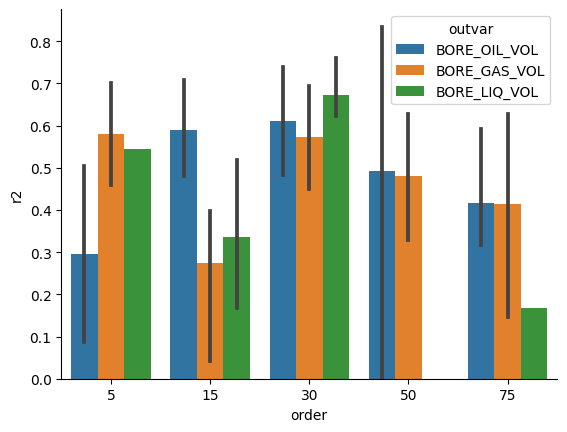

In [1289]:
sns.barplot(data=df_armax_results[df_armax_results['r2']>0], x='order', y='r2', hue='outvar');

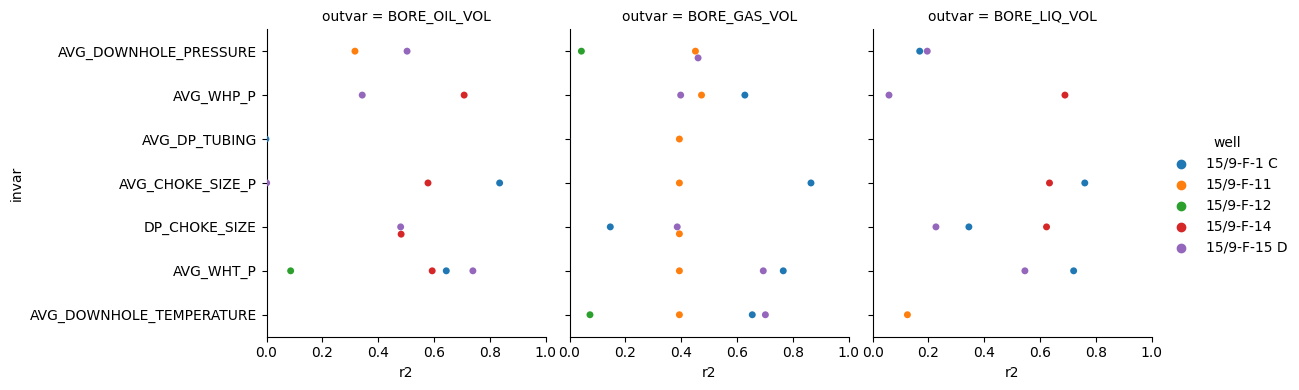

In [1290]:
sns.catplot(data=df_armax_results, y='invar', x='r2', hue='well', col='outvar', col_wrap=3, height=4, aspect=1, palette='tab10', kind='swarm')
plt.xlim((0,1))

# dfr.groupby(['well', 'invar'])['r2'].max().sort_values(ascending=False)

pass;

In [1291]:
df_armax_results.sort_values('r2', ascending=False).head(20)

outvar                     invar  n_inputs         well  \
10   BORE_GAS_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C   
3    BORE_OIL_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C   
12   BORE_GAS_VOL                 AVG_WHT_P         1   15/9-F-1 C   
17   BORE_LIQ_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C   
89   BORE_OIL_VOL                 AVG_WHT_P         1  15/9-F-15 D   
19   BORE_LIQ_VOL                 AVG_WHT_P         1   15/9-F-1 C   
64   BORE_OIL_VOL                 AVG_WHP_P         1    15/9-F-14   
97   BORE_GAS_VOL  AVG_DOWNHOLE_TEMPERATURE         1  15/9-F-15 D   
96   BORE_GAS_VOL                 AVG_WHT_P         1  15/9-F-15 D   
78   BORE_LIQ_VOL                 AVG_WHP_P         1    15/9-F-14   
13   BORE_GAS_VOL  AVG_DOWNHOLE_TEMPERATURE         1   15/9-F-1 C   
5    BORE_OIL_VOL                 AVG_WHT_P         1   15/9-F-1 C   
80   BORE_LIQ_VOL          AVG_CHOKE_SIZE_P         1    15/9-F-14   
8    BORE_GAS_VOL                 AVG_WHP_P         1   15/9-F-1 C   
81   BORE_LIQ_VOL             DP_CHOKE_SIZE         1    15/9-F-14   
68   BORE_OIL_VOL                 AVG_WHT_P         1    15/9-F-14   
66   BORE_OIL_VOL          AVG_CHOKE_SIZE_P         1    15/9-F-14   
103  BORE_LIQ_VOL                 AVG_WHT_P         1  15/9-F-15 D   
84   BORE_OIL_VOL     AVG_DOWNHOLE_PRESSURE         1  15/9-F-15 D   
67   BORE_OIL_VOL             DP_CHOKE_SIZE         1    15/9-F-14   

    model_class        r2                   mae  order  \
10        ARMAX  0.864350  [7.8034050504132235]     50   
3         ARMAX  0.834555   [34.04030399542236]     50   
12        ARMAX  0.765083   [10.65415187639645]     50   
17        ARMAX  0.759735  [153.40079247389383]     30   
89        ARMAX  0.738809  [26.530677631872386]     30   
19        ARMAX  0.719851   [169.5623005838727]     15   
64        ARMAX  0.707508             41.929005     15   
97        ARMAX  0.701080   [5.841388408802746]      5   
96        ARMAX  0.693542   [4.557951631717705]     30   
78        ARMAX  0.688741  [44.209930146557525]     15   
13        ARMAX  0.654153    [13.3396664794609]     50   
5         ARMAX  0.643524  [47.379293868726585]     50   
80        ARMAX  0.633361             48.170326     30   
8         ARMAX  0.627641  [12.161720855589245]     75   
81        ARMAX  0.622793             47.115091     30   
68        ARMAX  0.593085   [53.03417385623633]     75   
66        ARMAX  0.578068  [63.657068702442636]     15   
103       ARMAX  0.545340   [95.54807836525187]      5   
84        ARMAX  0.503177  [49.000802160136736]      5   
67        ARMAX  0.481863             62.410196     30   

                                                 model  \
10   <sysidentpy.model_structure_selection.forward_...   
3    <sysidentpy.model_structure_selection.forward_...   
12   <sysidentpy.model_structure_selection.forward_...   
17   <sysidentpy.model_structure_selection.forward_...   
89   <sysidentpy.model_structure_selection.forward_...   
19   <sysidentpy.model_structure_selection.forward_...   
64   <sysidentpy.model_structure_selection.forward_...   
97   <sysidentpy.model_structure_selection.forward_...   
96   <sysidentpy.model_structure_selection.forward_...   
78   <sysidentpy.model_structure_selection.forward_...   
13   <sysidentpy.model_structure_selection.forward_...   
5    <sysidentpy.model_structure_selection.forward_...   
80   <sysidentpy.model_structure_selection.forward_...   
8    <sysidentpy.model_structure_selection.forward_...   
81   <sysidentpy.model_structure_selection.forward_...   
68   <sysidentpy.model_structure_selection.forward_...   
66   <sysidentpy.model_structure_selection.forward_...   
103  <sysidentpy.model_structure_selection.forward_...   
84   <sysidentpy.model_structure_selection.forward_...   
67   <sysidentpy.model_structure_selection.forward_...   

                                                  y_te  \
10   [[58.901], [60.948], [64.122], [64.317]

In [1292]:
best_armax_model = df_armax_results.sort_values('r2', ascending=False).head(1).model.values[0]
r = pd.DataFrame(
    results(
        best_armax_model.final_model, best_armax_model.theta, best_armax_model.err, best_armax_model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r.iloc[:10]

Regressors   Parameters             ERR
0     y(k-1)   2.7795E-01  8.47130457E-01
1    y(k-33)   7.8162E-02  1.37518602E-02
2    x1(k-1)   6.2156E+01  8.20146029E-03
3   x1(k-34)   1.4087E+01  2.14715015E-03
4    y(k-48)   2.1530E-02  1.98595675E-03
5   x1(k-16)  -1.3736E+01  2.37399464E-03
6    y(k-37)   1.6851E-01  1.26377929E-03
7   x1(k-38)  -2.4277E+01  1.01534793E-03
8          1   4.7528E+00  1.13405522E-03
9   x1(k-19)  -1.7856E+01  9.13116178E-04

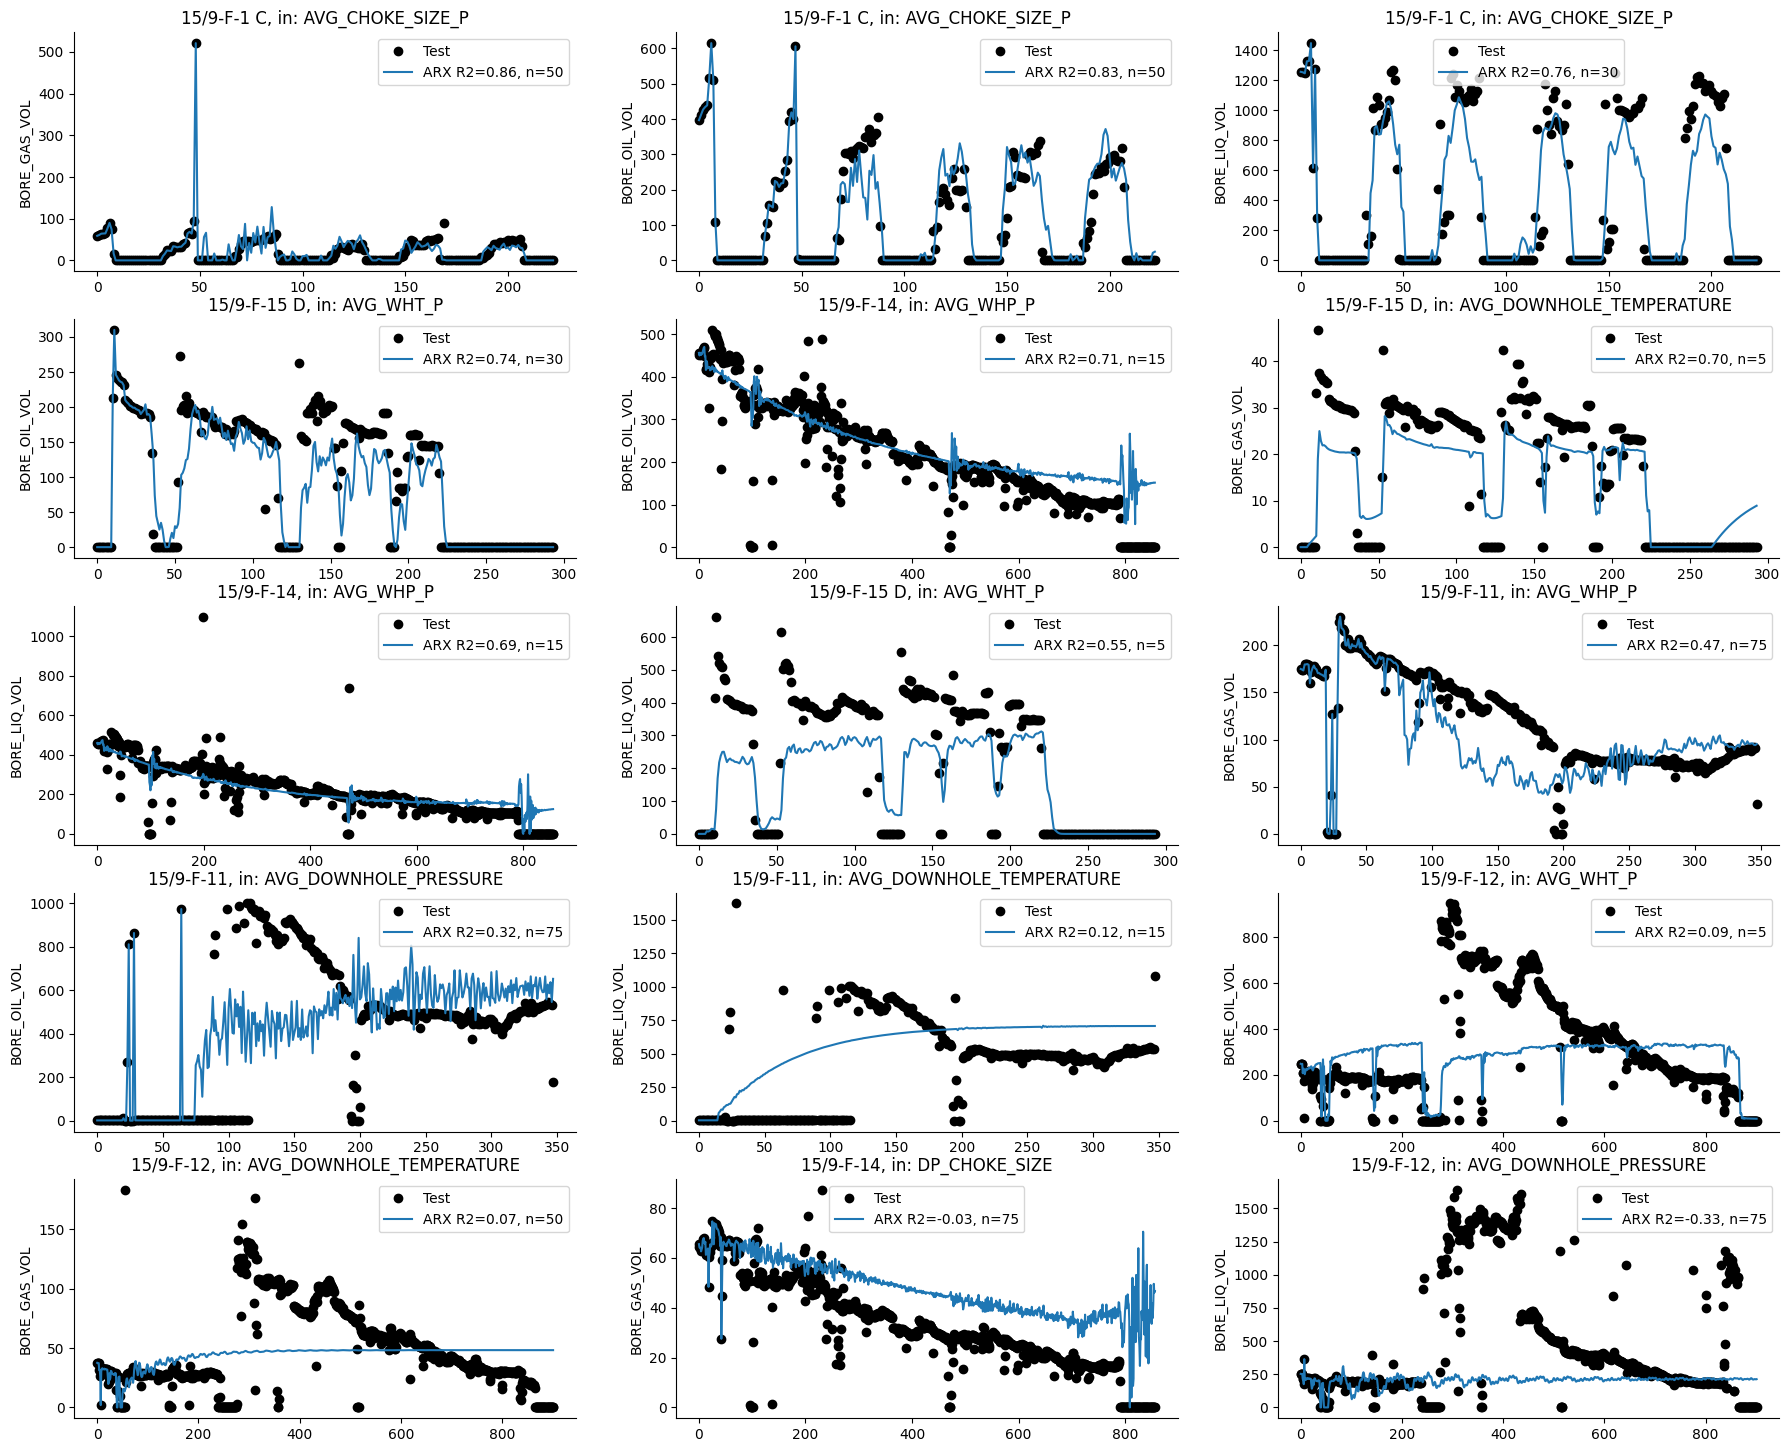

In [1293]:
# plotting best results
fig, ax = plt.subplots(5,3,figsize=(22,18))
ax = ax.flatten()
for i, m in enumerate(df_armax_results.sort_values('r2', ascending=False).drop_duplicates(['outvar' ,'well']).values):
    # print (m[:5])
    ax[i].plot(m[-2], 'ko', label='Test')
    ax[i].set_title(m[3]+', in: '+m[1])
    ax[i].set_ylabel(m[0])
    ax[i].plot(m[-1], label=f'ARX R2={m[5]:.2f}, n={m[7]}')
    ax[i].legend()
pass;

2ISO

In [1294]:
dict_armax_results2 = {
    'outvar':    [],
    'invar':     [],
    'well':      [],
    'n_inputs':      [],

    'model_class':     [],
    'r2':        [],
    'mae':       [],
    'order':    [],

    'model':     [],
    'y_te':     [],
    'y_pred':     [],
}

In [1295]:
# for well in [pwells[0]]:
for well in pwells[:-1]:
    print ('==================== Well '+well+' ================')
    for outvar in outvars:
        for invar in tqdm(combinations(best_invars,2), desc='Predicting '+outvar+'... Input vars loop'):
            invar = list(invar) # tuple to list

            ar_best_r2 = -100
            nar_best_r2 = -100

            X1 = df[df['NPD_WELL_BORE_NAME'] == well][invar].values.astype(float)
            y = df[df['NPD_WELL_BORE_NAME'] == well][outvar].values.astype(float)

            X1 = MinMaxScaler().fit_transform(X1)
            
            i_train = int(X1.shape[0]*p_train)
            
            X_tr = X1[:i_train] #.reshape(-1, 1)
            y_tr = y[:i_train].reshape(-1, 1)
            X_te = X1[i_train:] #.reshape(-1, 1)
            y_te = y[i_train:].reshape(-1, 1)

            for io, o in enumerate(orders):
                na = o
                nb = [o] * X1.shape[1]
                ne = o

                model_ARMAX = FROLS(
                    order_selection=True,
                    ylag=na, xlag=nb, 
                    elag=ne,
                    basis_function=Polynomial(degree=1),
                    n_terms=X1.shape[1] * o,
                    # model_type='NARMAX',
                    info_criteria='aic',
                    estimator='least_squares',
                    extended_least_squares=True,
                )
                model_ARMAX.fit(X=X_tr, y=y_tr)

                y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X_te, y=y_te, steps_ahead=steps_ahead)
                y_te_pr_FS_ARMAX = [0 if i < 0 else i for i in y_te_pr_FS_ARMAX]

                try:    
                    r2_ARMAX = r2_score(y_te, y_te_pr_FS_ARMAX)
                    if r2_ARMAX < -1000: r2_ARMAX = -1000                                            
                    mae_ARMAX = mae(y_te, y_te_pr_FS_ARMAX)
                except:
                    r2_ARMAX = 0
                    mae_ARMAX = 1e6
                pass

                if r2_ARMAX > ar_best_r2 and r2_ARMAX < 1: 
                    ar_best_order = o
                    ar_best_r2 = r2_ARMAX
                    ar_best_mae = mae_ARMAX
                    ar_best_model = model_ARMAX
                    ar_best_pred = y_te_pr_FS_ARMAX

            dict_armax_results2['well'].append(well)
            dict_armax_results2['outvar'].append(outvar)
            dict_armax_results2['invar'].append(invar)
            dict_armax_results2['n_inputs'].append(2)
            dict_armax_results2['model_class'].append('ARMAX')
            dict_armax_results2['r2'].append(ar_best_r2)
            dict_armax_results2['mae'].append(ar_best_mae)
            dict_armax_results2['order'].append(ar_best_order)
            dict_armax_results2['model'].append(ar_best_model)
            dict_armax_results2['y_te'].append(y_te)
            dict_armax_results2['y_pred'].append(ar_best_pred)
pass;

==================== Well 15/9-F-1 C ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [01:17, 12.96s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [01:18, 13.04s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [01:17, 12.90s/it]


==================== Well 15/9-F-11 ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [01:25, 14.30s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [01:25, 14.19s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [01:26, 14.35s/it]


==================== Well 15/9-F-12 ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [01:49, 18.27s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [01:48, 18.09s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [01:51, 18.52s/it]


==================== Well 15/9-F-14 ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [01:46, 17.83s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [01:49, 18.19s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [01:47, 17.93s/it]


==================== Well 15/9-F-15 D ================


Predicting BORE_OIL_VOL... Input vars loop: 6it [01:23, 13.91s/it]
Predicting BORE_GAS_VOL... Input vars loop: 6it [01:23, 13.98s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 6it [01:23, 13.97s/it]


3ISO

In [1296]:
dict_armax_results3 = {
    'outvar':    [],
    'invar':     [],
    'well':      [],
    'n_inputs':      [],

    'model_class':     [],
    'r2':        [],
    'mae':       [],
    'order':    [],

    'model':     [],
    'y_te':     [],
    'y_pred':     [],
}

In [1297]:
# for well in [pwells[0]]:
for well in pwells[:-1]:
    print ('==================== Well '+well+' ================')
    for outvar in outvars:
        for invar in tqdm(combinations(best_invars,3), desc='Predicting '+outvar+'... Input vars loop'):
            invar = list(invar) # tuple to list

            ar_best_r2 = -100
            nar_best_r2 = -100

            X1 = df[df['NPD_WELL_BORE_NAME'] == well][invar].values.astype(float)
            y = df[df['NPD_WELL_BORE_NAME'] == well][outvar].values.astype(float)

            X1 = MinMaxScaler().fit_transform(X1)
            
            i_train = int(X1.shape[0]*p_train)
            
            X_tr = X1[:i_train] #.reshape(-1, 1)
            y_tr = y[:i_train].reshape(-1, 1)
            X_te = X1[i_train:] #.reshape(-1, 1)
            y_te = y[i_train:].reshape(-1, 1)

            for io, o in enumerate(orders):
                na = o
                nb = [o] * X1.shape[1]
                ne = o

                model_ARMAX = FROLS(
                    order_selection=True,
                    ylag=na, xlag=nb, 
                    elag=ne,
                    basis_function=Polynomial(degree=1),
                    n_terms=X1.shape[1] * o,
                    # model_type='NARMAX',
                    info_criteria='aic',
                    estimator='least_squares',
                    extended_least_squares=True,
                )
                model_ARMAX.fit(X=X_tr, y=y_tr)

                y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X_te, y=y_te, steps_ahead=steps_ahead)
                y_te_pr_FS_ARMAX = [0 if i < 0 else i for i in y_te_pr_FS_ARMAX]

                try:    
                    r2_ARMAX = r2_score(y_te, y_te_pr_FS_ARMAX)
                    if r2_ARMAX < -1000: r2_ARMAX = -1000                                            
                    mae_ARMAX = mae(y_te, y_te_pr_FS_ARMAX)
                except:
                    r2_ARMAX = 0
                    mae_ARMAX = 1e6
                pass

                if r2_ARMAX > ar_best_r2 and r2_ARMAX < 1: 
                    ar_best_order = o
                    ar_best_r2 = r2_ARMAX
                    ar_best_mae = mae_ARMAX
                    ar_best_model = model_ARMAX
                    ar_best_pred = y_te_pr_FS_ARMAX

            dict_armax_results3['well'].append(well)
            dict_armax_results3['outvar'].append(outvar)
            dict_armax_results3['invar'].append(invar)
            dict_armax_results3['n_inputs'].append(3)
            dict_armax_results3['model_class'].append('ARMAX')
            dict_armax_results3['r2'].append(ar_best_r2)
            dict_armax_results3['mae'].append(ar_best_mae)
            dict_armax_results3['order'].append(ar_best_order)
            dict_armax_results3['model'].append(ar_best_model)
            dict_armax_results3['y_te'].append(y_te)
            dict_armax_results3['y_pred'].append(ar_best_pred)
pass;

==================== Well 15/9-F-1 C ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [00:53, 13.39s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [00:53, 13.35s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [00:52, 13.18s/it]


==================== Well 15/9-F-11 ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [00:58, 14.54s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [00:58, 14.72s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [00:59, 14.95s/it]


==================== Well 15/9-F-12 ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [01:14, 18.73s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [01:15, 18.89s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [01:14, 18.53s/it]


==================== Well 15/9-F-14 ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [01:13, 18.37s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [01:12, 18.20s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [01:12, 18.24s/it]


==================== Well 15/9-F-15 D ================


Predicting BORE_OIL_VOL... Input vars loop: 4it [00:57, 14.36s/it]
Predicting BORE_GAS_VOL... Input vars loop: 4it [00:56, 14.24s/it]
Predicting BORE_LIQ_VOL... Input vars loop: 4it [00:57, 14.35s/it]


In [1299]:
df_armax_results2 = pd.DataFrame(dict_armax_results2)
df_armax_results3 = pd.DataFrame(dict_armax_results3)

dfr_armax = df_armax_results.append(df_armax_results2).append(df_armax_results3)

In [1300]:
dfr_armax.sort_values('r2', ascending=False).head(10)

outvar                     invar  n_inputs         well model_class  \
10  BORE_GAS_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C       ARMAX   
3   BORE_OIL_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C       ARMAX   
12  BORE_GAS_VOL                 AVG_WHT_P         1   15/9-F-1 C       ARMAX   
17  BORE_LIQ_VOL          AVG_CHOKE_SIZE_P         1   15/9-F-1 C       ARMAX   
89  BORE_OIL_VOL                 AVG_WHT_P         1  15/9-F-15 D       ARMAX   
19  BORE_LIQ_VOL                 AVG_WHT_P         1   15/9-F-1 C       ARMAX   
64  BORE_OIL_VOL                 AVG_WHP_P         1    15/9-F-14       ARMAX   
97  BORE_GAS_VOL  AVG_DOWNHOLE_TEMPERATURE         1  15/9-F-15 D       ARMAX   
96  BORE_GAS_VOL                 AVG_WHT_P         1  15/9-F-15 D       ARMAX   
78  BORE_LIQ_VOL                 AVG_WHP_P         1    15/9-F-14       ARMAX   

          r2                   mae  order  \
10  0.864350  [7.8034050504132235]     50   
3   0.834555   [34.04030399542236]     50   
12  0.765083   [10.65415187639645]     50   
17  0.759735  [153.40079247389383]     30   
89  0.738809  [26.530677631872386]     30   
19  0.719851   [169.5623005838727]     15   
64  0.707508             41.929005     15   
97  0.701080   [5.841388408802746]      5   
96  0.693542   [4.557951631717705]     30   
78  0.688741  [44.209930146557525]     15   

                                                model  \
10  <sysidentpy.model_structure_selection.forward_...   
3   <sysidentpy.model_structure_selection.forward_...   
12  <sysidentpy.model_structure_selection.forward_...   
17  <sysidentpy.model_structure_selection.forward_...   
89  <sysidentpy.model_structure_selection.forward_...   
19  <sysidentpy.model_structure_selection.forward_...   
64  <sysidentpy.model_structure_selection.forward_...   
97  <sysidentpy.model_structure_selection.forward_...   
96  <sysidentpy.model_structure_selection.forward_...   
78  <sysidentpy.model_structure_selection.forward_...   

                                                 y_te  \
10  [[58.901], [60.948], [64.122], [64.317], [64.7...   
3   [[397.0], [412.0], [427.0], [434.0], [439.0], ...   
12  [[58.901], [60.948], [64.122], [64.317], [64.7...   
17  [[1255.0], [1252.0], [1245.0], [1325.0], [1327...   
89  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
19  [[1255.0], [1252.0], [1245.0], [1325.0], [1327...   
64  [[456.0], [450.0], [456.0], [456.0], [451.0], ...   
97  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
96  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
78  [[459.159], [453.055], [459.087], [459.178], [...   

                                               y_pred  
10  [[58.901], [60.948], [64.122], [64.317], [64.7...  
3   [[397.0], [412.0], [427.0], [434.0], [439.0], ...  
12  [[58.901], [60.948], [64.122], [64.317], [64.7...  
17  [[1255.0], [1252.0], [1245.0], [1325.0], [1327...  
89  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
19  [[1255.0], [1252.0], [1245.0], [1325.0], [1327...  
64  [[456.0], [450.0], [456.0], [456.0], [451.0], ...  
97  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.4770419...  
96  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
78  [[459.159], [453.055], [459.087], [459.178], [...

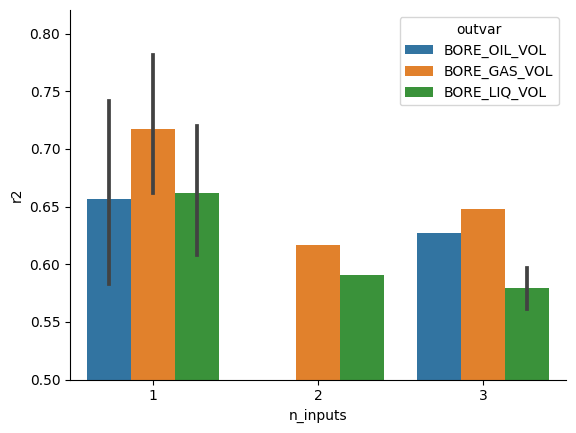

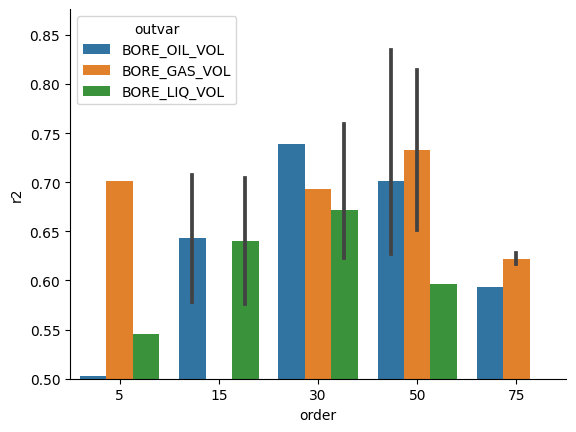

In [1301]:
sns.barplot(data=dfr_armax[dfr_armax['r2']>0.5], x='n_inputs', y='r2', hue='outvar')
plt.ylim((.5,None));
plt.figure()
sns.barplot(data=dfr_armax[dfr_armax['r2']>0.5], x='order', y='r2', hue='outvar')
plt.ylim((.5,None));

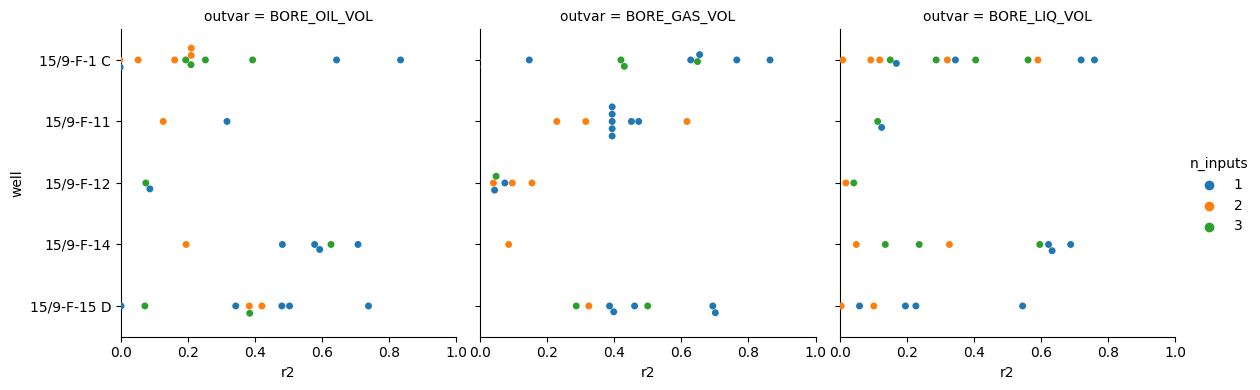

In [1302]:
sns.catplot(data=dfr_armax, y='well', x='r2', hue='n_inputs', col='outvar', col_wrap=3, height=4, aspect=1, palette='tab10', kind='swarm')
plt.xlim((0,1));

In [1304]:
dfr_armax.sort_values('r2', ascending=False).drop_duplicates(['outvar','well']).head(20)

outvar                                              invar  \
10   BORE_GAS_VOL                                   AVG_CHOKE_SIZE_P   
3    BORE_OIL_VOL                                   AVG_CHOKE_SIZE_P   
17   BORE_LIQ_VOL                                   AVG_CHOKE_SIZE_P   
89   BORE_OIL_VOL                                          AVG_WHT_P   
64   BORE_OIL_VOL                                          AVG_WHP_P   
97   BORE_GAS_VOL                           AVG_DOWNHOLE_TEMPERATURE   
78   BORE_LIQ_VOL                                          AVG_WHP_P   
26   BORE_GAS_VOL                 [AVG_DOWNHOLE_PRESSURE, AVG_WHT_P]   
103  BORE_LIQ_VOL                                          AVG_WHT_P   
21   BORE_OIL_VOL                              AVG_DOWNHOLE_PRESSURE   
45   BORE_GAS_VOL       [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE]   
41   BORE_LIQ_VOL                           AVG_DOWNHOLE_TEMPERATURE   
47   BORE_OIL_VOL                                          AVG_WHT_P   
64   BORE_GAS_VOL                      [AVG_CHOKE_SIZE_P, AVG_WHT_P]   
32   BORE_LIQ_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_CHOKE_SIZE_P, AVG_...   

     n_inputs         well model_class        r2                   mae  order  \
10          1   15/9-F-1 C       ARMAX  0.864350  [7.8034050504132235]     50   
3           1   15/9-F-1 C       ARMAX  0.834555   [34.04030399542236]     50   
17          1   15/9-F-1 C       ARMAX  0.759735  [153.40079247389383]     30   
89          1  15/9-F-15 D       ARMAX  0.738809  [26.530677631872386]     30   
64          1    15/9-F-14       ARMAX  0.707508             41.929005     15   
97          1  15/9-F-15 D       ARMAX  0.701080   [5.841388408802746]      5   
78          1    15/9-F-14       ARMAX  0.688741  [44.209930146557525]     15   
26          2    15/9-F-11       ARMAX  0.616453              20.00185     75   
103         1  15/9-F-15 D       ARMAX  0.545340   [95.54807836525187]      5   
21          1    15/9-F-11       ARMAX  0.316603            185.497045     75   
45          2    15/9-F-12       ARMAX  0.153800             21.458279     15   
41          1    15/9-F-11       ARMAX  0.124729            259.415111     15   
47          1    15/9-F-12       ARMAX  0.086384   [164.0551695023884]      5   
64          2    15/9-F-14       ARMAX  0.084319  [14.403490883229269]     75   
32          3    15/9-F-12       ARMAX  0.041565            309.861204     50   

                                                 model  \
10   <sysidentpy.model_structure_selection.forward_...   
3    <sysidentpy.model_structure_selection.forward_...   
17   <sysidentpy.model_structure_selection.forward_...   
89   <sysidentpy.model_structure_selection.forward_...   
64   <sysidentpy.model_structure_selection.forward_...   
97   <sysidentpy.model_structure_selection.forward_...   
78   <sysidentpy.model_structure_selection.forward_...   
26   <sysidentpy.model_structure_selection.forward_...   
103  <sysidentpy.model_structure_selection.forward_...   
21   <sysidentpy.model_structure_selection.forward_...   
45   <sysidentpy.model_structure_selection.forward_...   
41   <sysidentpy.model_structure_selection.forward_...   
47   <sysidentpy.model_structure_selection.forward_...   
64   <sysidentpy.model_structure_selection.forward_...   
32   <sysidentpy.model_structure_selection.forward_...   

                                                  y_te  \
10   [[58.901], [60.948], [64.122], [64.317], [64.7...   
3    [[397.0], [412.0], [427.0], [434.0], [439.0], ...   
17   [[1255.0], [1252.0], [1245.0], [1325.0], [1327...   
89   [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
64   [[456.0], [450.0], [456.0], [456.0], [451.0], ...   
97   [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
78   [[459.159], [453.055], [459.087], [459.178], [...   
26   [[174.901], [174.297], [173.374], [179.685], [...   
103  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
21   [[1.145], [1.149], [1.134], [1.189], [1.187], .

Save ARMAX results

In [1305]:
pickle.dump(dict_armax_results,open ('armax_dict_result.p', 'wb'))
pickle.dump(dict_armax_results2,open('armax_dict_result2.p', 'wb'))
pickle.dump(dict_armax_results3,open('armax_dict_result3.p', 'wb'))

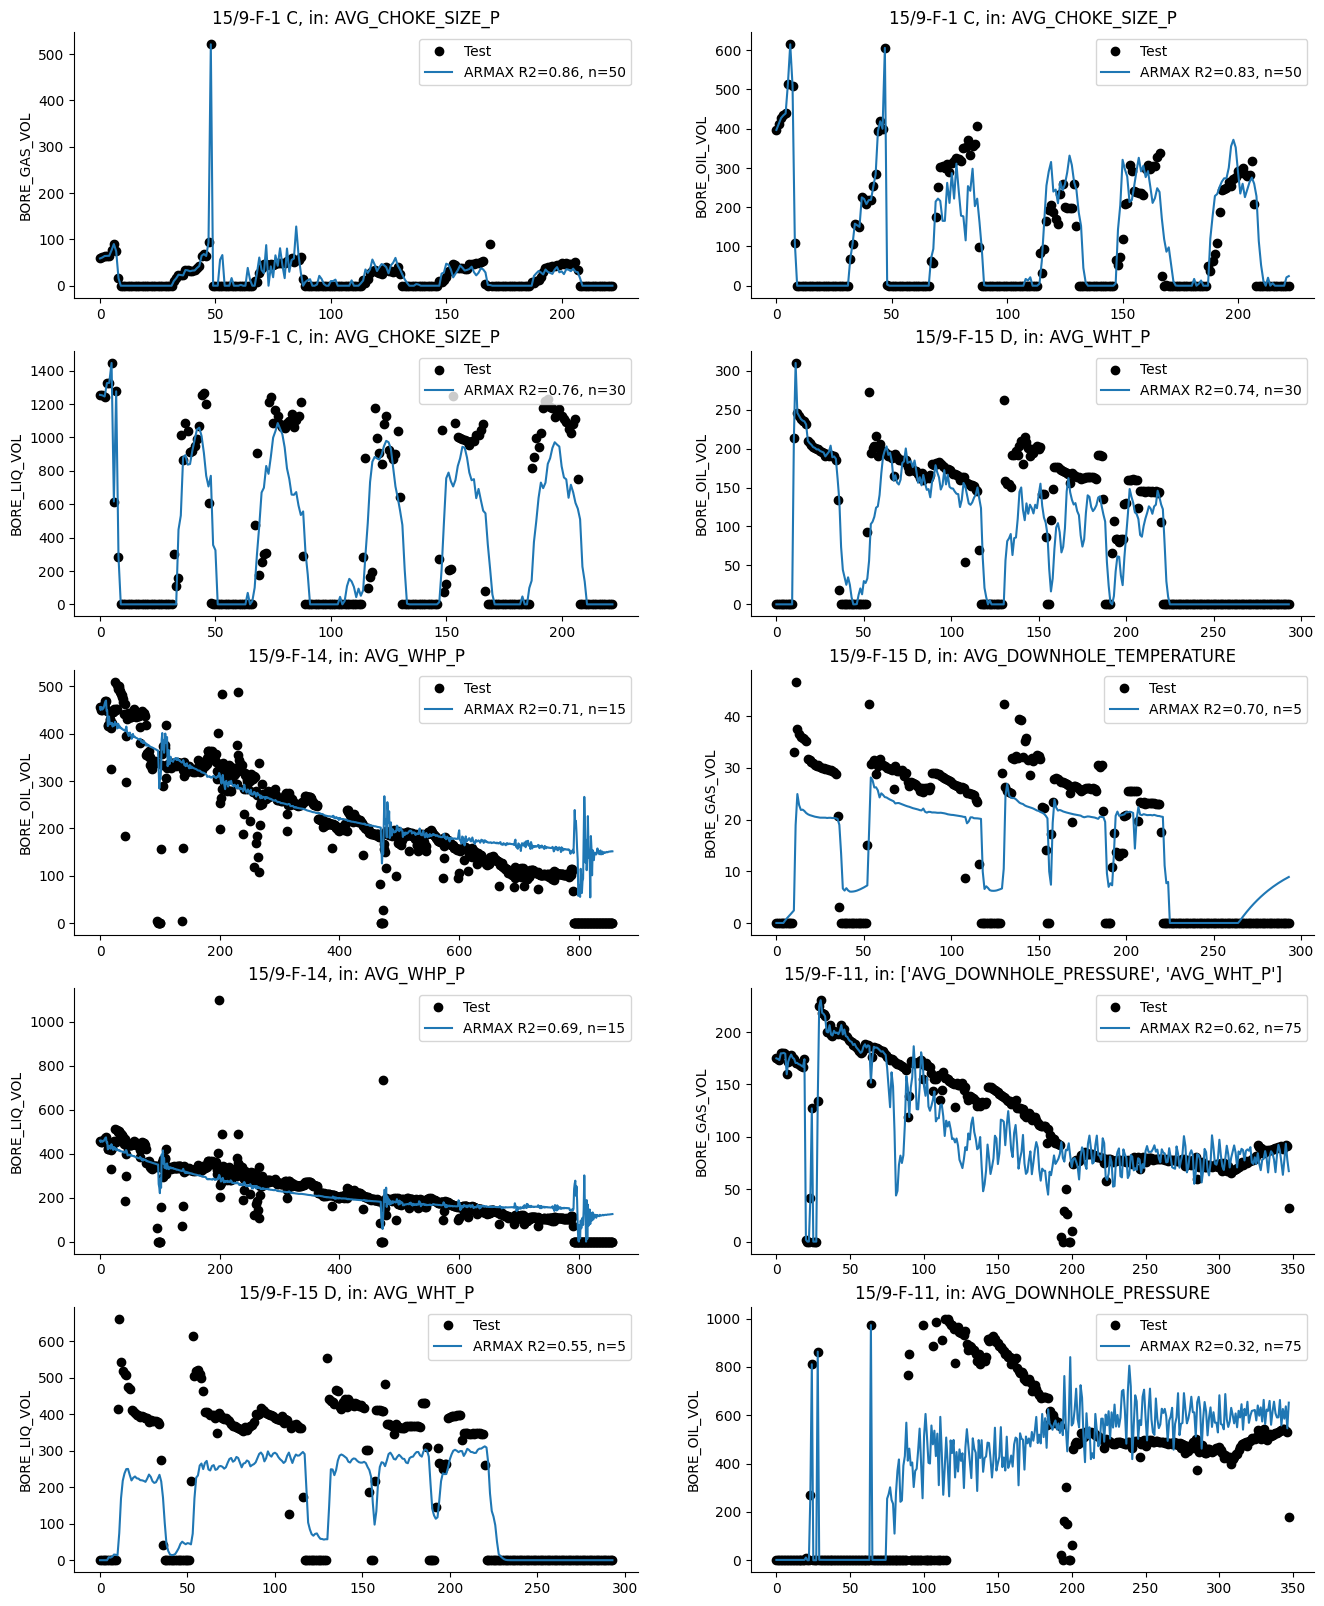

In [1306]:
# plotting best results
fig, ax = plt.subplots(5,2,figsize=(16,20))
ax = ax.flatten()
for i, m in enumerate(dfr_armax.sort_values('r2', ascending=False).drop_duplicates(['outvar','well']).head(10).values):
    # print (m[:5])
    ax[i].plot(m[-2], 'ko', label='Test')
    ax[i].set_title(m[3]+', in: '+str(m[1]))
    ax[i].set_ylabel(m[0])
    ax[i].plot(m[-1], label=f'ARMAX R2={m[5]:.2f}, n={m[7]}')
    ax[i].legend()
pass;


#### Comparing ARX x ARMAX

In [1309]:
dfr_lin = dfr.append(dfr_armax)

outvar                                              invar  n_inputs  \
0   BORE_OIL_VOL                              AVG_DOWNHOLE_PRESSURE         1   
1   BORE_OIL_VOL                                          AVG_WHP_P         1   
2   BORE_OIL_VOL                                      AVG_DP_TUBING         1   
3   BORE_OIL_VOL                                   AVG_CHOKE_SIZE_P         1   
4   BORE_OIL_VOL                                      DP_CHOKE_SIZE         1   
..           ...                                                ...       ...   
55  BORE_GAS_VOL  [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE, A...         3   
56  BORE_LIQ_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_CHOKE_SIZE_P, AVG_...         3   
57  BORE_LIQ_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_CHOKE_SIZE_P, AVG_...         3   
58  BORE_LIQ_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATU...         3   
59  BORE_LIQ_VOL  [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE, A...         3   

           well model_class        r2                   mae  order  \
0    15/9-F-1 C         ARX  0.771569   [38.73822690356595]     50   
1    15/9-F-1 C         ARX -1.083338            185.515629      5   
2    15/9-F-1 C         ARX -0.623391   [143.5514314284282]     50   
3    15/9-F-1 C         ARX  0.630590   [56.49722713421145]     75   
4    15/9-F-1 C         ARX -0.717038  [120.46033208390816]     75   
..          ...         ...       ...                   ...    ...   
55  15/9-F-15 D       ARMAX -0.437300   [10.74360846658536]     75   
56  15/9-F-15 D       ARMAX -1.394115   [223.5845457276879]     75   
57  15/9-F-15 D       ARMAX -0.285778   [150.7807734705604]     75   
58  15/9-F-15 D       ARMAX -7.964969   [440.1699934453708]      5   
59  15/9-F-15 D       ARMAX -0.555428   [158.9204652174303]     75   

                                                model  \
0   <sysidentpy.model_structure_selection.forward_...   
1   <sysidentpy.model_structure_selection.forward_...   
2   <sysidentpy.model_structure_selection.forward_...   
3   <sysidentpy.model_structure_selection.forward_...   
4   <sysidentpy.model_structure_selection.forward_...   
..                                                ...   
55  <sysidentpy.model_structure_selection.forward_...   
56  <sysidentpy.model_structure_selection.forward_...   
57  <sysidentpy.model_structure_selection.forward_...   
58  <sysidentpy.model_structure_selection.forward_...   
59  <sysidentpy.model_structure_selection.forward_...   

                                                 y_te  \
0   [[397.0], [412.0], [427.0], [434.0], [439.0], ...   
1   [[397.0], [412.0], [427.0], [434.0], [439.0], ...   
2   [[397.0], [412.0], [427.0], [434.0], [439.0], ...   
3   [[397.0], [412.0], [427.0], [434.0], [439.0], ...   
4   [[397.0], [412.0], [427.0], [434.0], [439.0], ...   
..                                                ...   
55  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
56  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
57  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
58  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
59  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                               y_pred  
0   [[397.0], [412.0], [427.0], [434.0], [439.0], ...  
1   [[397.0], [412.0], [427.0], [434.0], [439.0], ...  
2   [[397.0], [412.0], [427.0], [434.0], [439.0], ...  
3   [[397.0], [412.0], [427.0], [434.0], [439.0], ...  
4   [[397.0], [412.0], [427.0], [434.0], [439.0], ...  
..                                                ...  
55  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
56  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
57  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  
58  [[0.0], [0.0], [0.0], [0.0], [0.0], [9.4735070...  
59  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  

[510 rows x 11 columns]

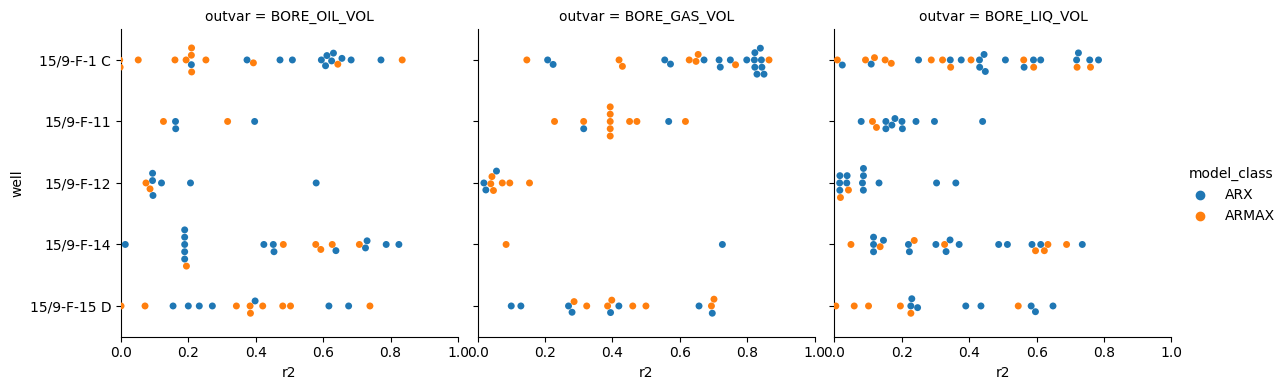

In [1315]:
sns.catplot(data=dfr_lin, y='well', x='r2', hue='model_class', col='outvar', col_wrap=3, height=4, aspect=1, palette='tab10', kind='swarm')
plt.xlim((0,1));

In [1399]:
dfr_lin.sort_values(['r2'], ascending=False).drop_duplicates(['outvar','well','model_class']).sort_values(['outvar', 'well'])

best_arx = dfr.sort_values(['r2'], ascending=False).drop_duplicates(['outvar','well']).sort_values(['outvar', 'well']).values
best_armax = dfr_armax.sort_values(['r2'], ascending=False).drop_duplicates(['outvar','well']).sort_values(['outvar', 'well']).values


outvar                                              invar  \
10   BORE_GAS_VOL                                   AVG_CHOKE_SIZE_P   
8    BORE_GAS_VOL                 [AVG_DOWNHOLE_PRESSURE, AVG_WHT_P]   
26   BORE_GAS_VOL                 [AVG_DOWNHOLE_PRESSURE, AVG_WHT_P]   
33   BORE_GAS_VOL                                          AVG_WHT_P   
45   BORE_GAS_VOL       [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE]   
29   BORE_GAS_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_CHOKE_SIZE_P, AVG_...   
61   BORE_GAS_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATURE]   
64   BORE_GAS_VOL                      [AVG_CHOKE_SIZE_P, AVG_WHT_P]   
97   BORE_GAS_VOL                           AVG_DOWNHOLE_TEMPERATURE   
97   BORE_GAS_VOL                           AVG_DOWNHOLE_TEMPERATURE   
17   BORE_LIQ_VOL                                   AVG_CHOKE_SIZE_P   
17   BORE_LIQ_VOL                                   AVG_CHOKE_SIZE_P   
31   BORE_LIQ_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATURE]   
41   BORE_LIQ_VOL                           AVG_DOWNHOLE_TEMPERATURE   
52   BORE_LIQ_VOL                      [AVG_CHOKE_SIZE_P, AVG_WHT_P]   
32   BORE_LIQ_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_CHOKE_SIZE_P, AVG_...   
69   BORE_LIQ_VOL       [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE]   
78   BORE_LIQ_VOL                                          AVG_WHP_P   
103  BORE_LIQ_VOL                                          AVG_WHT_P   
103  BORE_LIQ_VOL                                          AVG_WHT_P   
3    BORE_OIL_VOL                                   AVG_CHOKE_SIZE_P   
0    BORE_OIL_VOL                              AVG_DOWNHOLE_PRESSURE   
14   BORE_OIL_VOL  [AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATU...   
21   BORE_OIL_VOL                              AVG_DOWNHOLE_PRESSURE   
47   BORE_OIL_VOL                                          AVG_WHT_P   
47   BORE_OIL_VOL                                          AVG_WHT_P   
57   BORE_OIL_VOL       [AVG_CHOKE_SIZE_P, AVG_DOWNHOLE_TEMPERATURE]   
64   BORE_OIL_VOL                                          AVG_WHP_P   
89   BORE_OIL_VOL                                          AVG_WHT_P   
90   BORE_OIL_VOL                           AVG_DOWNHOLE_TEMPERATURE   

     n_inputs         well model_class        r2                   mae  order  \
10          1   15/9-F-1 C       ARMAX  0.864350  [7.8034050504132235]     50   
8           2   15/9-F-1 C         ARX  0.849497   [9.148103622978525]     75   
26          2    15/9-F-11       ARMAX  0.616453              20.00185     75   
33          1    15/9-F-11         ARX  0.566715   [24.43778001353486]     30   
45          2    15/9-F-12       ARMAX  0.153800             21.458279     15   
29          3    15/9-F-12         ARX  0.055852             26.465559     50   
61          2    15/9-F-14         ARX  0.726032              6.276376     75   
64          2    15/9-F-14       ARMAX  0.084319  [14.403490883229269]     75   
97          1  15/9-F-15 D       ARMAX  0.701080   [5.841388408802746]      5   
97          1  15/9-F-15 D         ARX  0.696051  [4.0913109726022885]     15   
17          1   15/9-F-1 C         ARX  0.783497  [136.90804725740222]     50   
17          1   15/9-F-1 C       ARMAX  0.759735  [153.40079247389383]     30   
31          2    15/9-F-11         ARX  0.439635            192.247601     50   
41          1    15/9-F-11       ARMAX  0.124729            259.415111     15   
52          2    15/9-F-12         ARX  0.360156            262.515748     30   
32          3    15/9-F-12       ARMAX  0.041565            309.861204     50   
69          2    15/9-F-14         ARX  0.735360             38.551202     30   
78          1    15/9-F-14       ARMAX  0.688741  [44.209930146557525]     15   
103         1  15/9-F-15 D         ARX  0.648426   [82.09893097475657]     15   
103         1  15/9-F-15 D       ARMAX  0.545340   [95.54807836525187]      5   
3           1   15/9-F-1 C       ARMAX  0.834555   [34.04030399542236]     50

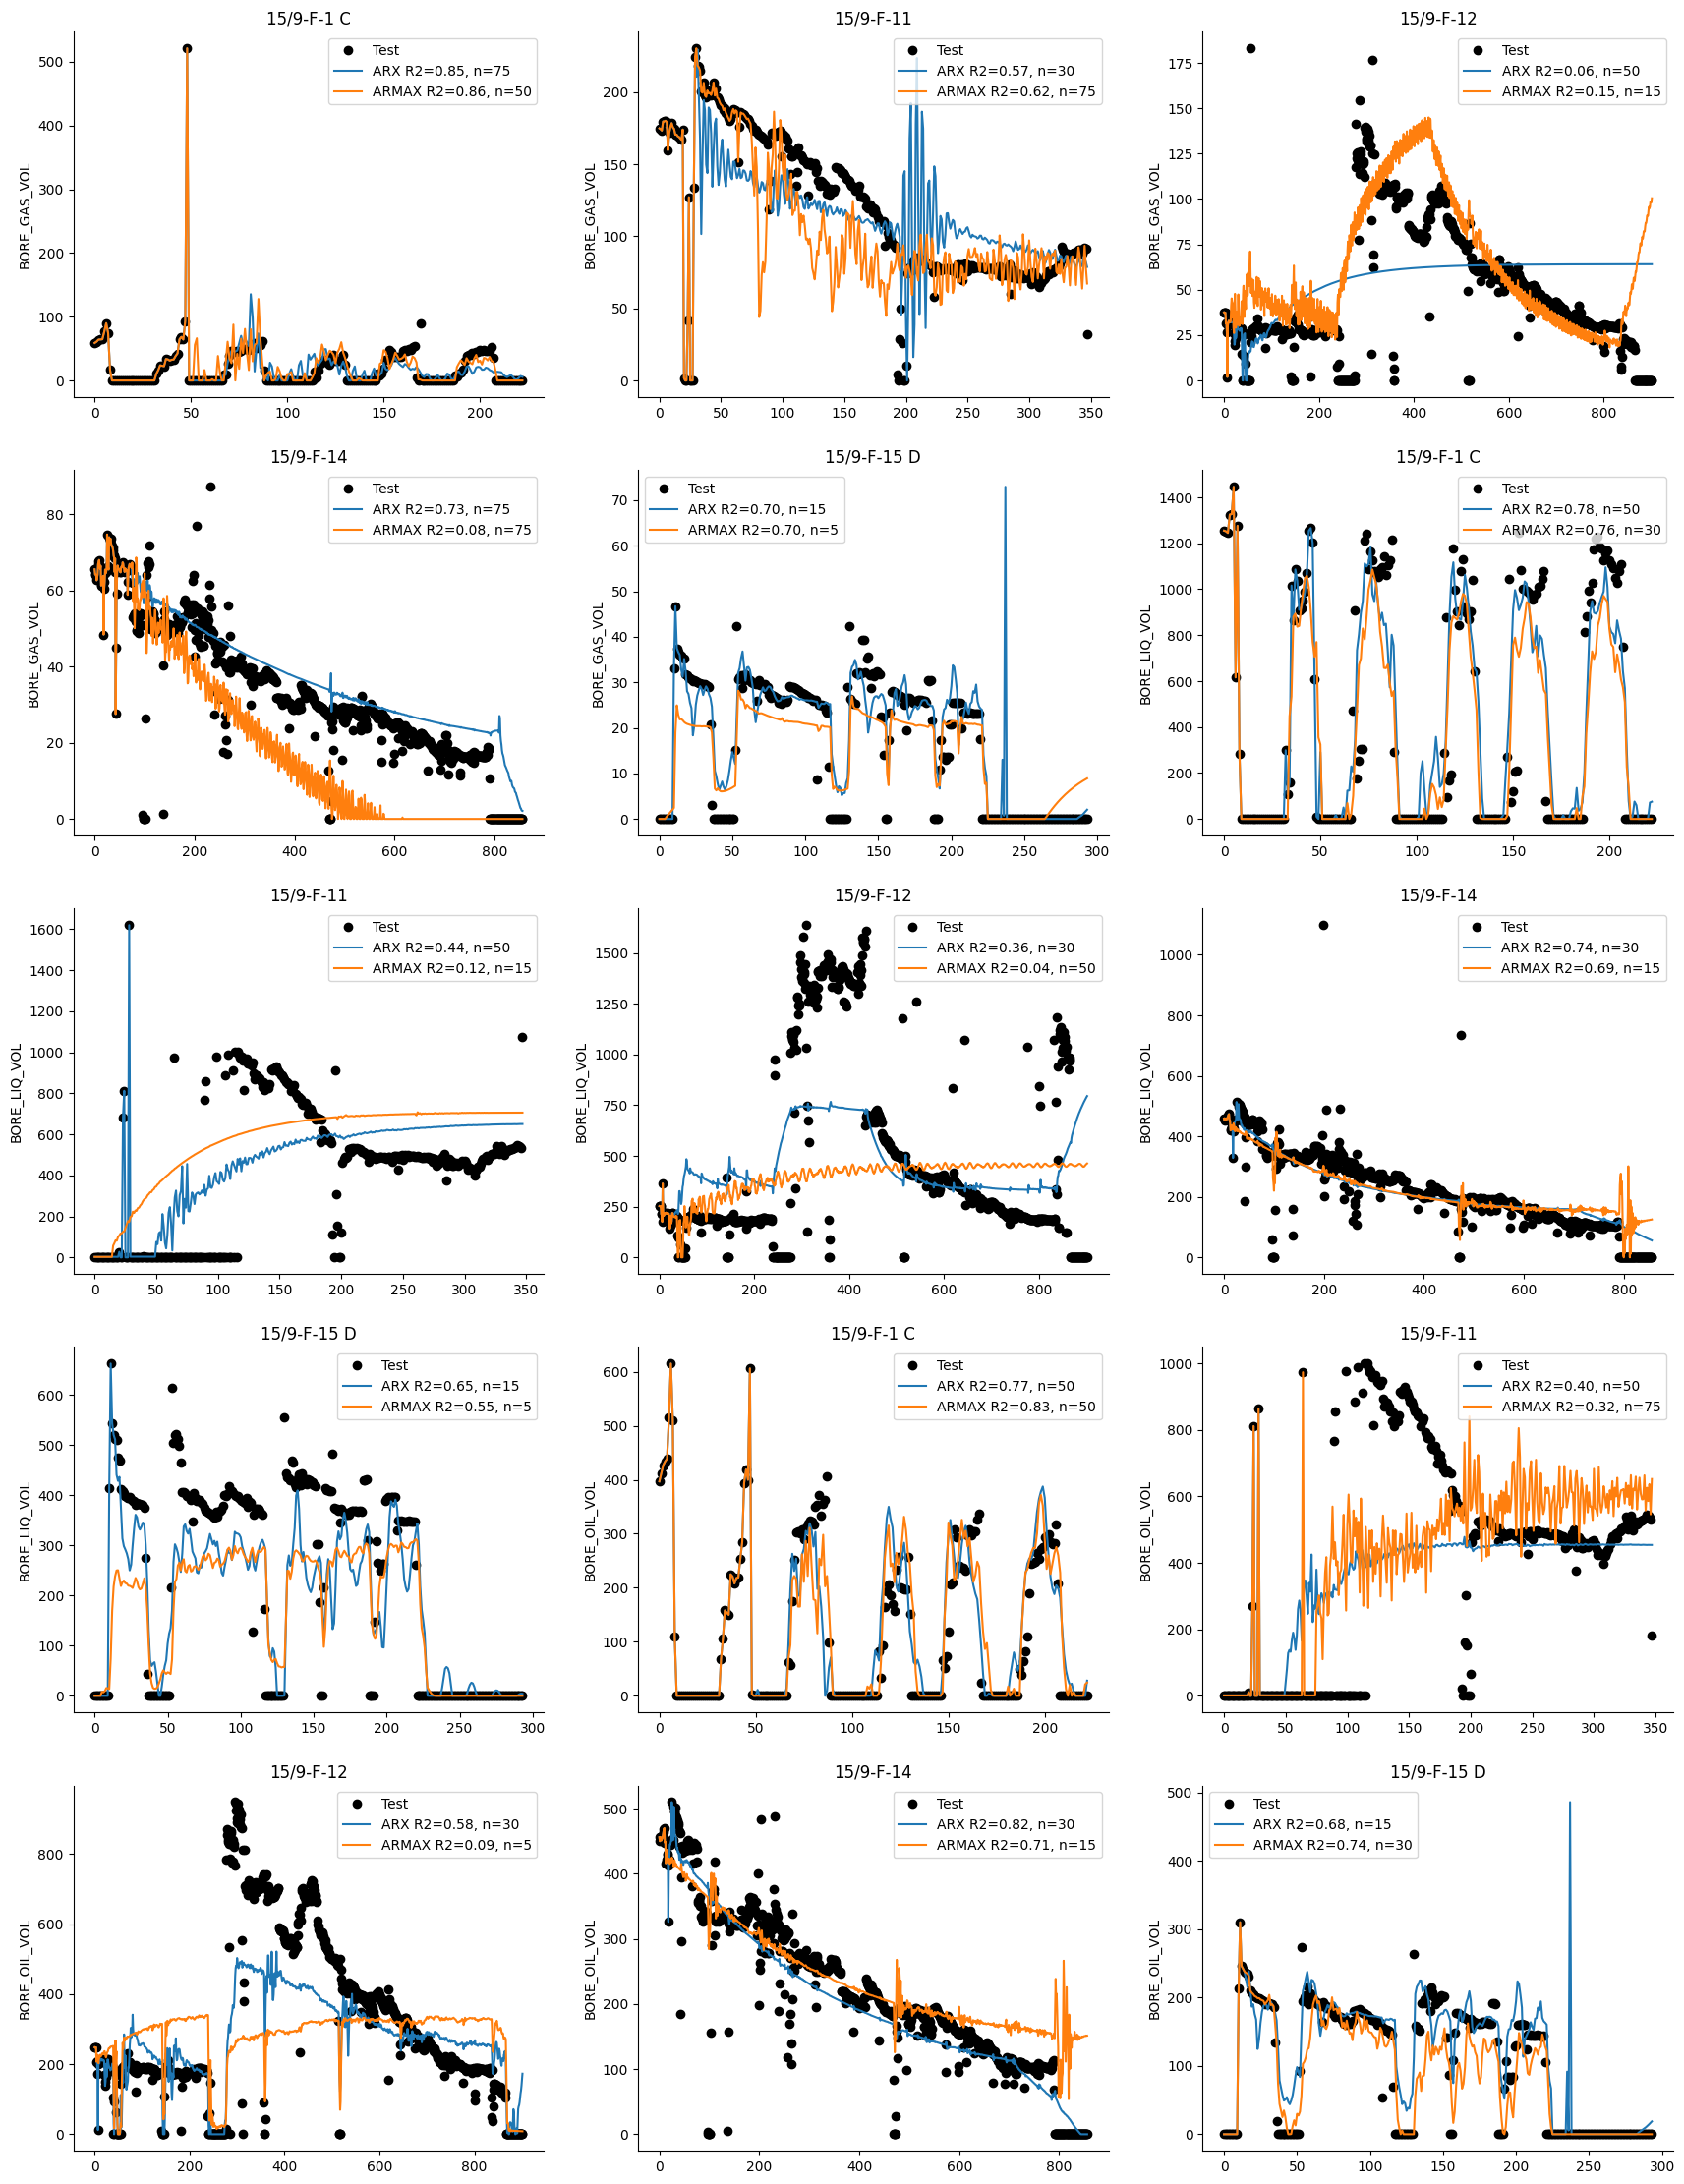

In [1390]:
# plotting best results
fig, ax = plt.subplots(5,3,figsize=(21,28))
ax = ax.flatten()
for i, (marx, marmax) in enumerate(zip(best_arx, best_armax)):
    ax[i].plot(marx[-2], 'ko', label='Test')
    ax[i].set_title(marx[3])
    ax[i].set_ylabel(marx[0])
    ax[i].plot(marx[-1], label=f'ARX R2={marx[5]:.2f}, n={marx[7]}')
    ax[i].plot(marmax[-1], label=f'ARMAX R2={marmax[5]:.2f}, n={marmax[7]}')
    ax[i].legend()
pass;